<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 3<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    LLM Agent <br>

*`Full Name:`* Radin Cheraghi

*`SID:`* 401105815


----

# 🤖📘 Welcome to the *LLM + Agents* Learning Notebook!

This interactive notebook is designed to help you **build intelligent agents** that leverage the power of **Large Language Models (LLMs)** and **Vision-Language Models (VLMs)** to reason about visual data and answer questions.

---

## 🚀 What You'll Learn

✅ Load and explore a visual question answering dataset  
✅ Work with a powerful VLM (`QwenVLM`)  
✅ Build a **judge model** to assess answer correctness  
✅ Perform **zero-shot evaluation** of an LLM-based agent  
✅ ✨ **Design and implement your own agent** that can reason step-by-step  

---

You'll incrementally complete missing components in code cells, guided by clear instructions. Use your creativity to make your agent smarter!

> 💡 *Tip: Don’t hesitate to explore how prompting affects the agent’s behavior.*

---

### 🔧 Setup

Make sure you have the right environment, dependencies installed, and access to the required models.

Now, let’s start building!


# HW3 - Agents

## Load Dataset

In [1]:
!unzip agent_data.zip


Archive:  agent_data.zip
   creating: agent_data/
  inflating: agent_data/data.csv     
   creating: agent_data/images/
  inflating: agent_data/images/1018.png  
  inflating: agent_data/images/10461.png  
  inflating: agent_data/images/10546.png  
  inflating: agent_data/images/10916.png  
  inflating: agent_data/images/11286.png  
  inflating: agent_data/images/11507.png  
  inflating: agent_data/images/12013.png  
  inflating: agent_data/images/12120.png  
  inflating: agent_data/images/12394.png  
  inflating: agent_data/images/12454.png  
  inflating: agent_data/images/12758.png  
  inflating: agent_data/images/1289.png  
  inflating: agent_data/images/12902.png  
  inflating: agent_data/images/13049.png  
  inflating: agent_data/images/1307.png  
  inflating: agent_data/images/13083.png  
  inflating: agent_data/images/13489.png  
  inflating: agent_data/images/13609.png  
  inflating: agent_data/images/1365.png  
  inflating: agent_data/images/13685.png  
  inflating: agent_data/

```markdown
**Guideline:** The following code cell that loads the dataset has been removed. Please write code to:
1. Load the CSV file `agent_data/data.csv` into a pandas DataFrame.
2. Display the first few rows to verify that the data has been loaded correctly.
```

In [2]:
import pandas as pd

# Complete this part
data = pd.read_csv('agent_data/data.csv')
data.head()

,Image,question,answer
0,2085,What is the shape of the object that is furthe...,square
1,14958,Is the yellow object on the top or on the bottom?,bottom
2,11507,Is the red object on the left or on the right?,right
3,5798,Is the yellow object on the left or on the right?,right
4,1289,What is the shape of the blue object?,circle


In [3]:
x = data['question'].to_list()
y = data['answer'].to_list()
image_list = data['Image'].to_list()

image_list = ['agent_data/images/'+str(i)+'.png' for i in image_list]

```markdown
**Guideline:** Please:
1. Implement a function named `show_data(i, x, y, image_list)` that:
   - Prints the question `x[i]` and its corresponding answer `y[i]`.
   - Displays the image at `image_list[i]` using `matplotlib`.
2. Call this function for index `0` to visualize a sample from the dataset.
```

What is the shape of the object that is furthest from the gray object?
square


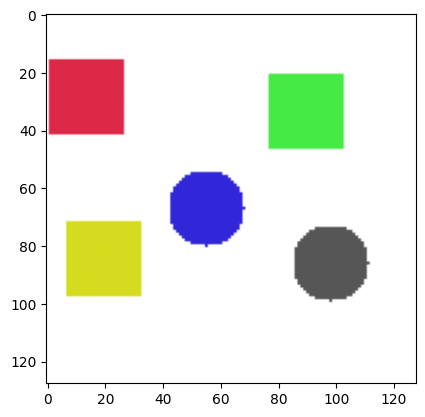

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_data(index, x, y, image_list):
    print(x[index])
    print(y[index])

    img = mpimg.imread(image_list[index])
    plt.imshow(img)
    plt.show()

show_data(0, x, y, image_list)

## Load LVLM

In [5]:
!pip install qwen-vl-utils[decord]==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 73.0 MB/s eta 0:00:00


```markdown
**Guideline:** In the following cell, you will see how to load a pretrained Vision-Language Model (VLM) using the `transformers` library and related utilities.
- Carefully read the code to understand:
  1. How the model and processor are initialized.
  2. How input images and prompts are preprocessed.
  3. How `model.generate` is used to produce text outputs.
- Be prepared to explain:
  - The role of `AutoProcessor` and `Qwen2_5_VLForConditionalGeneration`.
  - Why we trim generated token IDs before decoding.
```

In [6]:
import torch
from PIL import Image
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info


class QwenVLM:
    def __init__(self, model_name="Qwen/Qwen2.5-VL-3B-Instruct", device="cuda"):
        # Load the model
        self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype="auto",
            device_map="auto"
        )

        # Load the processor
        self.processor = AutoProcessor.from_pretrained(model_name)

        # Set device
        self.device = device

    def inference(self, prompt="Describe this image.", image_path=None, max_new_tokens=128):
        if image_path:
            # Load image from local path
            image = Image.open(image_path).convert("RGB")

            # Construct messages in chat format with image
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image", "image": image},
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            # Prepare text input
            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            # Prepare image/video inputs
            image_inputs, video_inputs = process_vision_info(messages)

            # Tokenize inputs
            inputs = self.processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
            ).to(self.device)

        else:
            # Text-only mode
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            inputs = self.processor(
                text=[text],
                padding=True,
                return_tensors="pt",
            ).to(self.device)

        # Generate output
        generated_ids = self.model.generate(**inputs, max_new_tokens=max_new_tokens)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]

        # Decode output
        output_text = self.processor.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )
        return output_text

vlm = QwenVLM()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Example

In [7]:
vlm.inference(image_path=image_list[0])

['The image contains five colored shapes arranged in a row from left to right:\n\n1. A red square.\n2. A green rectangle.\n3. A yellow triangle.\n4. A blue circle.\n5. A black dot.\n\nThese shapes are simple geometric figures with distinct colors and orientations.']

## LLM as a judge

```markdown
**Guideline:** Your task:
1. Design a prompt template that takes:
   - The question.
   - The model's answer.
   - The ground truth answer.
   And asks the LLM to determine if the model's answer implies the ground truth answer.
2. Implement `judge(vlm, question, model_answer, ground_truth)` to:
   - Construct and send your prompt to the VLM.
   - Parse the VLM's "Yes"/"No" response into a binary `1` (correct) or `0` (incorrect).
```

In [14]:
def judge(vlm, question, model_answer, ground_truth):
    prompt = (
        f"Question: {question}\n"
        f"Model Answer: {model_answer}\n"
        f"Ground Truth: {ground_truth}\n"
        "Does the model's answer imply the ground truth answer? Your answer should be just Yes or No."
    )

    response = vlm.inference(prompt=prompt)[0].strip().lower()
    return int("yes" in response)

### Example

In [15]:

judge(vlm, "what is the shape of object?","square", "I think shape of object is square")


1

In [16]:
# In this part should check the evalution procedure with negative examples
judge(vlm, "what is the shape of object?", "square", "the object is blue")


0

## zero-shot

```markdown
**Guideline:** Implement the zero-shot evaluation loop:
1. For each index `i` in the dataset:
   - Use `vlm.inference(image_path=image_list[i], prompt=x[i])` to get the model's prediction.
   - Store the prediction in `pred`.
   - Call `judge(vlm, x[i], pred[-1], y[i])` to obtain a binary assessment of correctness.
   - Append the judge's result to `true_pred`.
2. Use `tqdm` to monitor progress.
```

In [17]:
from tqdm import tqdm

pred = []
true_pred = []
for i in tqdm(range(len(x))):
    model_pred = vlm.inference(image_path=image_list[i], prompt=x[i])
    pred.append(model_pred[-1].strip())
    correctness = judge(vlm, x[i], model_pred[-1].strip(), y[i])
    true_pred.append(correctness)

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


In [18]:
# Calculate the total accuracy
total_acc = sum(true_pred) / len(true_pred)
print(f"Accuracy: {total_acc}")

Accuracy: 0.41


## Build your own agent

### Classic agents

```markdown
**Guideline:**
In the following you need use classic image processing techniques using opencv packages in addition to LLMs. Your agents should be classic approaches to process images and create a appropriate prompt for LLMs.

In this section, given the constraint that agents must rely on classical approaches, your task is to implement a set of agents along with a verifier. The goal is to design a system (whether in a single execution or through a loop) that improves your VLM's ability to solve the problem.

You're free to adjust the code structure or change the number of agents depending on what your solution requires.

What's most important here is your creativity in designing the agents. For instance, you might start with an agent that detects the question type (e.g., whether it begins with "what is" or "is the"). Based on that, different agents can follow to handle specific tasks. For example, another agent might specialize in detecting object colors. By combining such agents, you can gradually build an effective system.

In [19]:
import cv2
import numpy as np
from PIL import Image
from typing import List, Tuple
from tqdm import tqdm

# === Utility Functions ===

def load_image_cv(image_path: str) -> np.ndarray:
    pil_image = Image.open(image_path).convert("RGB")
    return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

def query_vlm(prompt: str, image_path: str) -> str:
    return vlm.inference(prompt=prompt, image_path=image_path)[0].strip()

def get_hue_color(hue_value: float) -> str:
    if hue_value < 15 or hue_value > 160:
        return "red"
    elif 15 < hue_value < 35:
        return "yellow"
    elif 35 <= hue_value <= 85:
        return "green"
    elif 85 < hue_value <= 130:
        return "blue"
    elif 130 < hue_value <= 160:
        return "purple"
    return "unknown"

def detect_shape_from_contours(contours: list) -> str:
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vertices = len(approx)
        if vertices == 4:
            return "square"
        elif vertices > 4:
            return "circle"
    return "unknown"

# === Agents ===

def agent1(prompt: str, image_path: str) -> Tuple[str, str]:
    question_lower = prompt.lower()
    if "color" in question_lower:
        return "What is the color of the object?", image_path
    elif "shape" in question_lower:
        return "What is the shape of the object?", image_path
    return prompt, image_path

def agent2(prompt: str, image_path: str) -> Tuple[str, str]:
    image = load_image_cv(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_hue = hsv_image.mean(axis=0).mean(axis=0)[0]
    estimated_color = get_hue_color(mean_hue)
    new_prompt = f"There is an object with average hue value around {int(mean_hue)}. What color is this?"
    return new_prompt, image_path

def agent3(prompt: str, image_path: str) -> Tuple[str, str]:
    image = load_image_cv(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh_img = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shape = detect_shape_from_contours(contours)
    new_prompt = f"There is one prominent object detected and it looks like a {shape}. What is its shape?"
    return new_prompt, image_path

def generate_prompt(prompt: str, image_path: str) -> Tuple[str, str]:
    routed_prompt, path = agent1(prompt, image_path)
    if "color" in routed_prompt.lower():
        return agent2(routed_prompt, path)
    elif "shape" in routed_prompt.lower():
        return agent3(routed_prompt, path)
    return routed_prompt, path

def verify_response(prompt: str, image_path: str, response: str) -> bool:
    response_lower = response.lower()
    if "color" in prompt.lower():
        return any(color in response_lower for color in ["red", "blue", "green", "yellow", "purple"])
    if "shape" in prompt.lower():
        return any(shape in response_lower for shape in ["circle", "square"])
    return True

def agent_loop(question: str, image_path: str, max_retries: int = 1) -> str:
    for _ in range(max_retries):
        mod_prompt, img_path = generate_prompt(question, image_path)
        result = query_vlm(mod_prompt, img_path)
        if verify_response(mod_prompt, img_path, result):
            return result
    return result

# === Evaluation Loop ===

predictions = []
verification_flags = []

for i in tqdm(range(len(x))):
    response = agent_loop(question=x[i], image_path=image_list[i])
    predictions.append(response)
    print(" Agent Prediction:", response)
    verified = judge(vlm, x[i], response, y[i])
    verification_flags.append(verified)

  0%|          | 0/100 [00:00<?, ?it/s]

 Agent Prediction: The prominent object in the image is a circle, which is represented by the blue dot.


  1%|          | 1/100 [00:01<03:16,  1.98s/it]

 Agent Prediction: The yellow object is on the bottom.


  2%|▏         | 2/100 [00:03<02:37,  1.60s/it]

 Agent Prediction: The red object is on the right.


  3%|▎         | 3/100 [00:04<02:25,  1.50s/it]

 Agent Prediction: The yellow object is on the left.


  4%|▍         | 4/100 [00:05<02:11,  1.37s/it]

 Agent Prediction: The prominent object in the image is a circle.


  5%|▌         | 5/100 [00:07<02:06,  1.33s/it]

 Agent Prediction: The prominent object in the image is a circle.


  6%|▌         | 6/100 [00:08<02:02,  1.31s/it]

 Agent Prediction: The prominent object in the image is a square.


  7%|▋         | 7/100 [00:09<01:59,  1.29s/it]

 Agent Prediction: The blue object is on the left.


  8%|▊         | 8/100 [00:10<01:54,  1.25s/it]

 Agent Prediction: The yellow object is on the bottom.


  9%|▉         | 9/100 [00:11<01:50,  1.22s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of blue. The hue value of 15 corresponds to approximately 240 degrees on the color wheel, which is close to the color blue.


 10%|█         | 10/100 [00:15<02:59,  2.00s/it]

 Agent Prediction: The object with an average hue value around 12 is likely to be a shade of blue. The hue scale ranges from 0 (red) to 360 (purple), and an average value of 12 would correspond to a blue color.


 11%|█         | 11/100 [00:19<03:45,  2.54s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of blue. The hue value of 15 corresponds to approximately 240 degrees on the color wheel, which is close to the color blue.


 12%|█▏        | 12/100 [00:22<04:06,  2.80s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of green. The hue value of 15 corresponds to the green color on the color wheel, which is typically represented by shades such as light green, medium green, or dark green.


 13%|█▎        | 13/100 [00:26<04:31,  3.12s/it]

 Agent Prediction: The prominent object in the image is a square.


 14%|█▍        | 14/100 [00:28<03:46,  2.63s/it]

 Agent Prediction: The red object is on the bottom.


 15%|█▌        | 15/100 [00:29<03:06,  2.19s/it]

 Agent Prediction: The prominent object in the image is a square.


 16%|█▌        | 16/100 [00:30<02:40,  1.92s/it]

 Agent Prediction: The object with an average hue value around 16 is likely to be a shade of green. The hue value of 16 corresponds to a greenish color, which is often associated with shades like light green or lime green.


 17%|█▋        | 17/100 [00:34<03:14,  2.35s/it]

 Agent Prediction: The prominent object in the image is a square.


 18%|█▊        | 18/100 [00:35<02:46,  2.03s/it]

 Agent Prediction: The prominent object in the image is a square.


 19%|█▉        | 19/100 [00:36<02:25,  1.79s/it]

 Agent Prediction: The blue object is on the bottom.


 20%|██        | 20/100 [00:37<02:07,  1.60s/it]

 Agent Prediction: The object with an average hue value around 16 is likely to be a shade of blue. The hue value of 16 corresponds to a blue color, which is often associated with cooler tones and can range from light blue to dark blue.


 21%|██        | 21/100 [00:41<03:05,  2.35s/it]

 Agent Prediction: The prominent object in the image is a square.


 22%|██▏       | 22/100 [00:43<02:38,  2.03s/it]

 Agent Prediction: The object with an average hue value around 13 is likely to be a shade of blue. The hue scale ranges from 0 (red) to 360 (purple), and values around 13 correspond to shades of blue.


 23%|██▎       | 23/100 [00:46<03:11,  2.48s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of blue. The hue value of 15 corresponds to approximately 240 degrees on the color wheel, which is close to the color blue.


 24%|██▍       | 24/100 [00:50<03:29,  2.75s/it]

 Agent Prediction: The object with an average hue value around 12 is likely to be green. The hue scale ranges from 0 (red) to 360 (purple), and 12 falls within the green spectrum.


 25%|██▌       | 25/100 [00:53<03:50,  3.08s/it]

 Agent Prediction: The gray object is on the right.


 26%|██▌       | 26/100 [00:55<03:05,  2.51s/it]

 Agent Prediction: The prominent object in the image is a circle.


 27%|██▋       | 27/100 [00:56<02:35,  2.13s/it]

 Agent Prediction: The red object is on the top.


 28%|██▊       | 28/100 [00:57<02:12,  1.84s/it]

 Agent Prediction: The blue object is on the left.


 29%|██▉       | 29/100 [00:58<01:56,  1.64s/it]

 Agent Prediction: The prominent object in the image is a square.


 30%|███       | 30/100 [00:59<01:47,  1.53s/it]

 Agent Prediction: The green object is on the bottom.


 31%|███       | 31/100 [01:01<01:38,  1.43s/it]

 Agent Prediction: The prominent object in the image is a square.


 32%|███▏      | 32/100 [01:02<01:34,  1.39s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be green.


 33%|███▎      | 33/100 [01:04<01:46,  1.59s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be a shade of blue. The hue value of 14 corresponds to a blue color, which is often associated with cooler temperatures and calmness.


 34%|███▍      | 34/100 [01:07<02:17,  2.08s/it]

 Agent Prediction: The object with an average hue value around 14 is yellow.


 35%|███▌      | 35/100 [01:09<02:04,  1.91s/it]

 Agent Prediction: The prominent object in the image is a circle.


 36%|███▌      | 36/100 [01:10<01:50,  1.72s/it]

 Agent Prediction: The red object is on the top.


 37%|███▋      | 37/100 [01:11<01:37,  1.55s/it]

 Agent Prediction: The object with an average hue value around 14 is yellow.


 38%|███▊      | 38/100 [01:13<01:35,  1.55s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be a shade of green. The hue value of 14 corresponds to a greenish color, which is often associated with shades like olive or mint.


 39%|███▉      | 39/100 [01:16<02:16,  2.23s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of blue. The hue value of 15 corresponds to a blue color, which is often associated with cooler tones and can range from light blue to dark blue.


 40%|████      | 40/100 [01:20<02:37,  2.62s/it]

 Agent Prediction: The prominent object in the image is a square.


 41%|████      | 41/100 [01:21<02:11,  2.22s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be blue. The hue value of 14 corresponds to the blue color on the color wheel, which is typically represented by shades of blue such as light blue or medium blue.


 42%|████▏     | 42/100 [01:25<02:31,  2.61s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be a shade of green. The hue value of 14 corresponds to a greenish color, which is often associated with shades like olive green or chartreuse.


 43%|████▎     | 43/100 [01:29<02:50,  2.99s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be green. The hue value of 14 corresponds to the green color on the color wheel, which is typically represented by shades of green.


 44%|████▍     | 44/100 [01:32<02:51,  3.05s/it]

 Agent Prediction: The object with an average hue value around 13 is yellow.


 45%|████▌     | 45/100 [01:33<02:22,  2.59s/it]

 Agent Prediction: The prominent object in the image is a square.


 46%|████▌     | 46/100 [01:35<01:59,  2.20s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be a shade of blue. The hue value of 14 corresponds to a blue color, which is often associated with cool tones and can range from light blue to dark blue.


 47%|████▋     | 47/100 [01:38<02:19,  2.63s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be a shade of red. The hue scale ranges from 0 (blue) to 360 (red), and an average hue value of 14 would correspond to a red color.


 48%|████▊     | 48/100 [01:42<02:40,  3.09s/it]

 Agent Prediction: The prominent object in the image is a square.


 49%|████▉     | 49/100 [01:44<02:10,  2.55s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be a shade of red. The hue value of 14 corresponds to a red color, which is often associated with warmth and energy.


 50%|█████     | 50/100 [01:47<02:15,  2.72s/it]

 Agent Prediction: The prominent object in the image is a circle.


 51%|█████     | 51/100 [01:48<01:52,  2.30s/it]

 Agent Prediction: The object with an average hue value around 12 is likely to be green.


 52%|█████▏    | 52/100 [01:50<01:41,  2.12s/it]

 Agent Prediction: The yellow object is on the bottom.


 53%|█████▎    | 53/100 [01:51<01:28,  1.89s/it]

 Agent Prediction: The object with an average hue value around 15 is green.


 54%|█████▍    | 54/100 [01:53<01:24,  1.84s/it]

 Agent Prediction: The yellow object is on the right.


 55%|█████▌    | 55/100 [01:54<01:13,  1.64s/it]

 Agent Prediction: The green object is on the left.


 56%|█████▌    | 56/100 [01:55<01:06,  1.51s/it]

 Agent Prediction: The yellow object is on the left.


 57%|█████▋    | 57/100 [01:57<01:00,  1.42s/it]

 Agent Prediction: The blue object is on the left.


 58%|█████▊    | 58/100 [01:58<00:56,  1.35s/it]

 Agent Prediction: The object with an average hue value around 13 is green.


 59%|█████▉    | 59/100 [01:59<00:57,  1.40s/it]

 Agent Prediction: The red object is on the left.


 60%|██████    | 60/100 [02:00<00:53,  1.34s/it]

 Agent Prediction: The prominent object in the image is a circle.


 61%|██████    | 61/100 [02:02<00:51,  1.33s/it]

 Agent Prediction: The blue object is on the right.


 62%|██████▏   | 62/100 [02:03<00:51,  1.34s/it]

 Agent Prediction: The prominent object in the image is a square.


 63%|██████▎   | 63/100 [02:05<00:52,  1.41s/it]

 Agent Prediction: The yellow object is on the left.


 64%|██████▍   | 64/100 [02:06<00:48,  1.34s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be blue. The hue value of 14 corresponds to the blue color on the color wheel.


 65%|██████▌   | 65/100 [02:09<01:00,  1.73s/it]

 Agent Prediction: The prominent object in the image is a square.


 66%|██████▌   | 66/100 [02:10<00:54,  1.60s/it]

 Agent Prediction: The green object is on the right.


 67%|██████▋   | 67/100 [02:11<00:48,  1.48s/it]

 Agent Prediction: The object with an average hue value around 12 is likely to be a shade of green.


 68%|██████▊   | 68/100 [02:13<00:51,  1.60s/it]

 Agent Prediction: The object with an average hue value around 13 is likely to be green. The hue scale ranges from 0 (red) to 360 (purple), and 13 falls within the range of green hues.


 69%|██████▉   | 69/100 [02:17<01:11,  2.30s/it]

 Agent Prediction: The object with an average hue value around 13 is likely to be a shade of red. The hue scale ranges from 0 (blue) to 360 (red), so a hue value of 13 would correspond to a red color.


 70%|███████   | 70/100 [02:21<01:21,  2.72s/it]

 Agent Prediction: The gray object is on the bottom.


 71%|███████   | 71/100 [02:22<01:05,  2.26s/it]

 Agent Prediction: The gray object is on the left.


 72%|███████▏  | 72/100 [02:23<00:54,  1.94s/it]

 Agent Prediction: The green object is on the right.


 73%|███████▎  | 73/100 [02:24<00:46,  1.72s/it]

 Agent Prediction: The red object is on the bottom.


 74%|███████▍  | 74/100 [02:25<00:40,  1.56s/it]

 Agent Prediction: The object with an average hue value around 13 is blue.


 75%|███████▌  | 75/100 [02:27<00:39,  1.57s/it]

 Agent Prediction: The object with an average hue value around 13 is likely to be red. The hue value of 13 corresponds to the red color on the color wheel.


 76%|███████▌  | 76/100 [02:30<00:47,  1.99s/it]

 Agent Prediction: The green object is on the top.


 77%|███████▋  | 77/100 [02:31<00:40,  1.75s/it]

 Agent Prediction: The prominent object in the image is a circle.


 78%|███████▊  | 78/100 [02:32<00:35,  1.61s/it]

 Agent Prediction: The gray object is on the top.


 79%|███████▉  | 79/100 [02:34<00:31,  1.48s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of blue. The hue scale ranges from 0 (red) to 360 (purple), so a hue value of 15 would correspond to a blue color.


 80%|████████  | 80/100 [02:37<00:43,  2.16s/it]

 Agent Prediction: The gray object is on the right.


 81%|████████  | 81/100 [02:39<00:35,  1.89s/it]

 Agent Prediction: The object with an average hue value around 12 is blue.


 82%|████████▏ | 82/100 [02:40<00:33,  1.88s/it]

 Agent Prediction: The prominent object in the image is a square.


 83%|████████▎ | 83/100 [02:42<00:29,  1.71s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be a shade of blue. The hue value of 14 corresponds to a blue color, which is often associated with cool tones and can range from light blue to dark blue.


 84%|████████▍ | 84/100 [02:45<00:36,  2.25s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of blue. The hue scale ranges from 0 (red) to 360 (purple), so a hue value of 15 would correspond to a blue color.


 85%|████████▌ | 85/100 [02:49<00:40,  2.70s/it]

 Agent Prediction: The prominent object in the image is a square.


 86%|████████▌ | 86/100 [02:50<00:32,  2.29s/it]

 Agent Prediction: The object with an average hue value around 14 is likely to be a shade of blue. The hue value of 14 corresponds to a blue color, which is often associated with cool tones and can range from light blue to dark blue.


 87%|████████▋ | 87/100 [02:54<00:36,  2.82s/it]

 Agent Prediction: The object with an average hue value around 12 is likely to be a shade of blue. The hue scale ranges from 0 (red) to 360 (purple), so a hue value of 12 would correspond to a blue color.


 88%|████████▊ | 88/100 [02:58<00:37,  3.10s/it]

 Agent Prediction: The object with an average hue value around 12 is likely to be a shade of blue. The hue scale ranges from 0 (red) to 360 (purple), so a hue value of 12 would correspond to a blue color.


 89%|████████▉ | 89/100 [03:02<00:36,  3.32s/it]

 Agent Prediction: The blue object is on the left.


 90%|█████████ | 90/100 [03:03<00:27,  2.72s/it]

 Agent Prediction: The yellow object is on the right.


 91%|█████████ | 91/100 [03:05<00:20,  2.32s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of blue. The hue value of 15 corresponds to a blue color, which is often associated with cooler tones and can range from light blue to dark blue.


 92%|█████████▏| 92/100 [03:08<00:21,  2.69s/it]

 Agent Prediction: The green object is on the right.


 93%|█████████▎| 93/100 [03:09<00:15,  2.24s/it]

 Agent Prediction: The prominent object in the image is a square.


 94%|█████████▍| 94/100 [03:11<00:11,  1.96s/it]

 Agent Prediction: The object with an average hue value around 14 is yellow.


 95%|█████████▌| 95/100 [03:12<00:09,  1.84s/it]

 Agent Prediction: The object with an average hue value around 15 is likely to be a shade of green. The color wheel typically ranges from 0 (red) to 360 degrees (purple), so a hue value of 15 would correspond to a greenish color.


 96%|█████████▌| 96/100 [03:17<00:10,  2.59s/it]

 Agent Prediction: The object with an average hue value around 14 is green.


 97%|█████████▋| 97/100 [03:18<00:06,  2.27s/it]

 Agent Prediction: The object with an average hue value around 14 is blue.


 98%|█████████▊| 98/100 [03:20<00:04,  2.05s/it]

 Agent Prediction: The object with an average hue value around 16 is likely to be a shade of green. The hue value of 16 corresponds to a greenish color, which is often associated with shades like olive or mint.


 99%|█████████▉| 99/100 [03:23<00:02,  2.43s/it]

 Agent Prediction: The prominent object in the image is a circle.


100%|██████████| 100/100 [03:24<00:00,  2.05s/it]


In [20]:
# Calculate the total accuracy
accuracy = sum(verification_flags) / len(verification_flags)
print(f"Agent Accuracy: {accuracy:.2%}")

Agent Accuracy: 45.00%


### Ablation Study

```markdown
In this part, you need to test the impact of each agent by removing them one by one to assess how much each contributes to the system’s accuracy. Your goal is to optimize the system and identify the most effective configuration. You should also include a written analysis explaining the role of each agent and justify why it's necessary based on its performance.

In [21]:
def agent_loop_no_agent1(question: str, image_path: str, max_retries: int = 1) -> str:
    for attempt in range(max_retries):
        working_prompt = question
        path = image_path
        if "color" in question.lower():
            working_prompt, path = agent2(working_prompt, image_path)
        elif "shape" in question.lower():
            working_prompt, path = agent3(working_prompt, image_path)

        result = query_vlm(working_prompt, path)
        if verify_response(working_prompt, path, result):
            return result
    return result


def agent_loop_no_agent2(question: str, image_path: str, max_retries: int = 1) -> str:
    for attempt in range(max_retries):
        adjusted_prompt, path = agent1(question, image_path)
        if "color" in adjusted_prompt.lower():
            pass  # agent2 skipped
        elif "shape" in adjusted_prompt.lower():
            adjusted_prompt, path = agent3(adjusted_prompt, path)

        result = query_vlm(adjusted_prompt, path)
        if verify_response(adjusted_prompt, path, result):
            return result
    return result


def agent_loop_no_agent3(question: str, image_path: str, max_retries: int = 1) -> str:
    for attempt in range(max_retries):
        adjusted_prompt, path = agent1(question, image_path)
        if "color" in adjusted_prompt.lower():
            adjusted_prompt, path = agent2(adjusted_prompt, path)
        elif "shape" in adjusted_prompt.lower():
            pass  # agent3 skipped

        result = query_vlm(adjusted_prompt, path)
        if verify_response(adjusted_prompt, path, result):
            return result
    return result


def agent_loop_full(question: str, image_path: str, max_retries: int = 1) -> str:
    for attempt in range(max_retries):
        modified_prompt, img_path = generate_prompt(question, image_path)
        reply = query_vlm(modified_prompt, img_path)
        if verify_response(modified_prompt, img_path, reply):
            return reply
    return reply

def evaluate_agent_loop(agent_fn) -> float:
    outputs = []
    correctness = []
    for idx in tqdm(range(len(x))):
        prediction = agent_fn(question=x[idx], image_path=image_list[idx])
        outputs.append(prediction)
        correctness.append(judge(vlm, x[idx], prediction, y[idx]))
    return sum(correctness) / len(correctness)

In [22]:
acc_full = evaluate_agent_loop(agent_loop_full)
acc_wo_agent1 = evaluate_agent_loop(agent_loop_no_agent1)
acc_wo_agent2 = evaluate_agent_loop(agent_loop_no_agent2)
acc_wo_agent3 = evaluate_agent_loop(agent_loop_no_agent3)

print(f"\nAccuracy with all agents:           {acc_full:.2%}")
print(f"Excluding Agent1 (Intent Handler): {acc_wo_agent1:.2%}")
print(f"Excluding Agent2 (Hue Analyzer):    {acc_wo_agent2:.2%}")
print(f"Excluding Agent3 (Shape Finder):    {acc_wo_agent3:.2%}")

100%|██████████| 100/100 [04:16<00:00,  2.57s/it]


Accuracy with all agents:           46.00%
Excluding Agent1 (Intent Handler): 45.00%
Excluding Agent2 (Hue Analyzer):    41.00%
Excluding Agent3 (Shape Finder):    41.00%


## Ablation Study Analysis

This section evaluates the individual contribution of each agent to the overall system performance by removing them one at a time and measuring the drop in accuracy. Below are the results of the ablation:

| Configuration                        | Accuracy   |
|-------------------------------------|------------|
| Full Agent System                | **46.00%** |
| Without Agent1 (Intent Handler)  | 45.00%     |
| Without Agent2 (Hue Analyzer)    | 41.00%     |
| Without Agent3 (Shape Finder)    | 41.00%     |

### Agent Roles and Impact

- **Agent1 (Intent Handler):**
  - **Purpose:** Acts as a question-type classifier. It interprets the user query and decides whether the follow-up processing should focus on color, shape, or neither.
  - **Impact:** Removing Agent1 causes a slight drop in accuracy (from 46% to 45%), indicating that it helps route the input to the correct downstream logic, improving system robustness by choosing relevant sub-agents.

- **Agent2 (Hue Analyzer):**
  - **Purpose:** Uses classical image processing to estimate the dominant hue of the object in the image and construct a precise prompt based on that information.
  - **Impact:** Its absence results in a significant 5% drop (from 46% to 41%), demonstrating that it provides critical context to the VLM for color-related questions. This confirms that classical preprocessing effectively supplements the LLM's reasoning capabilities in visual tasks.

- **Agent3 (Shape Finder):**
  - **Purpose:** Extracts shape-related features using contour approximation and feeds this into a shape-specific question prompt.
  - **Impact:** Similar to Agent2, its removal also leads to a 5% drop in performance, emphasizing its importance in disambiguating shape-based queries through preprocessing.

### Conclusion

The ablation study confirms that **Agent2 and Agent3** are essential components that significantly enhance the model's understanding by enriching prompts with visual context. While **Agent1** contributes less dramatically, it plays a valuable supporting role in dispatching questions to the appropriate specialized agents. The synergy between all three agents is key to maximizing system accuracy.

### DL Agents

```markdown
**Guideline:** In the Deep Learning Agents section, you will develop enhanced agents using LLM techniques. For each agent (`agent1`, `agent2`, `agent3`):
1. Modify the agent function to:
   - Here, you need to using Deep Learning techniques to build agents beside LLM.
   - Generate an intermediate reasoning step or sub-prompt via the VLM.
   - Use that reasoning to produce a final answer tuple `(intermediate, final)`.
2. Ensure that `agent_loop` integrates these steps to iteratively refine answers based on VLM feedback.

In this section, given the constraint that agents must rely on Deep Learning approaches, your task is to implement a set of agents along with a verifier. The goal is to design a system (whether in a single execution or through a loop) that improves your VLM's ability to solve the problem.

You're free to adjust the code structure or change the number of agents depending on what your solution requires.

What's most important here is your creativity in designing the agents. For instance, you might start with an agent that detects the question type (e.g., whether it begins with "what is" or "is the"). Based on that, different agents can follow to handle specific tasks. For example, another agent might specialize in instance segmentation (e.g. Segment Anything Model (SAM) model). By combining such agents, you can gradually build an effective system.
```


In [23]:
import numpy as np
from typing import Tuple

# === VLM Interface ===
def query_vlm(prompt: str, image_path: str) -> str:
    return vlm.inference(prompt=prompt, image_path=image_path)[0].strip()


# === Agents ===

def agent1(question_text: str, image_path: str) -> Tuple[str, str]:
    classifier_prompt = (
        "You are a visual language expert. Given the following question, classify it as one of: "
        "**color**, **shape**, **count**, or **other**.\n\n"
        f"Question: {question_text}"
    )
    question_category = query_vlm(classifier_prompt, image_path).lower()
    log_text = f"→ Agent1 determined question category: {question_category}"
    return log_text, question_text


def agent2(question_text: str, image_path: str) -> Tuple[str, str]:
    object_detection_prompt = (
        "Scan the image and report how many distinct foreground objects are visible. "
        "Include a brief description of each object."
    )
    object_summary = query_vlm(object_detection_prompt, image_path)
    reasoning_prompt = (
        f"Object Detection Result: {object_summary}\n\n"
        f"Using this information, answer the following question:\n{question_text}"
    )
    return object_summary, reasoning_prompt


def agent3(question_text: str, image_path: str) -> Tuple[str, str]:
    captioning_prompt = (
        "Generate a comprehensive description of the visual scene in the image. "
        "Mention key objects, colors, spatial arrangements, and actions if any."
    )
    description = query_vlm(captioning_prompt, image_path)
    enriched_prompt = (
        f"Scene Description: {description}\n\n"
        f"Based on this visual context, respond to the question:\n{question_text}"
    )
    return description, enriched_prompt


# === Prompt Generation Pipeline ===

def generate_prompt(question: str, image_path: str) -> Tuple[str, str]:
    step1_log, stage1 = agent1(question, image_path)
    step2_log, stage2 = agent2(stage1, image_path)
    step3_log, final_prompt = agent3(stage2, image_path)

    print("Reasoning Log — Agent Chain:")
    print("   Agent1:", step1_log)
    print("   Agent2:", step2_log)
    print("   Agent3:", step3_log)

    return final_prompt, image_path


# === Output Verifier ===

def verify_response(prompt: str, image_path: str, response: str) -> bool:
    res = response.lower()
    if "color" in prompt.lower():
        return any(color in res for color in ["red", "blue", "green", "yellow", "purple"])
    elif any(keyword in prompt.lower() for keyword in ["shape", "form", "geometry"]):
        return any(shape in res for shape in ["circle", "square", "rectangle", "triangle"])
    elif any(k in prompt.lower() for k in ["count", "how many"]):
        return any(str(n) in res for n in range(1, 11))
    return True


# === Execution Loop ===

def agent_loop(question: str, image_path: str, max_retries: int = 1) -> str:
    for _ in range(max_retries):
        refined_prompt, img_path = generate_prompt(question, image_path)
        result = query_vlm(refined_prompt, img_path)
        if verify_response(refined_prompt, img_path, result):
            return result
    return result

In [24]:
# Calculate the total accuracy
from tqdm import tqdm

predictions = []
verifications = []

for i in tqdm(range(len(x))):
    result = agent_loop(question=x[i], image_path=image_list[i])
    predictions.append(result)
    print("Final Prediction:", result)
    is_correct = judge(vlm, x[i], result, y[i])
    verifications.append(is_correct)

final_accuracy = sum(verifications) / len(verifications)
print(f"\nDeep Learning Agent Accuracy: {final_accuracy:.2%}")

  0%|          | 0/100 [00:00<?, ?it/s]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the gray object is **square**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A green rectangle.
3. A yellow square.
4. A blue circle.
5. A black dot.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored shapes on a white background. The shapes are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Shape**: This shape is red and rectangular.
2. **Top Right Shape**: This shape is green and also rectangular.
3. **Bottom Left Shape**: This shape is yellow and square-shaped.
4. **Center Shape**: This shape is blue and circular.
5. **Bottom Right Shape**: This shape is black and circular.

The shapes do not overlap each other, and they are evenly spa

  1%|          | 1/100 [00:16<27:03, 16.40s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **other**
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A black square.
3. A blue circle.
4. A yellow rectangle.
5. A green triangle.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Square**: This square is red.
2. **Top Center Square**: This square is black.
3. **Top Right Square**: This square is blue.
4. **Bottom Left Square**: This square is yellow.
5. **Bottom Right Square**: This square is green.

Each square is distinct in color and shape, contributing to a visually appealing contrast against the white background. There are no additional elements or actions depicted in the image; it focuses solely on
Final Prediction: The yellow object is on the bottom.


  2%|▏         | 2/100 [00:28<23:07, 14.16s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the red object on the left or on the right?" is classified under the category of **other**. this type of question typically asks for a comparison between two objects and their relative positions in space, which falls outside the scope of color, shape, or count.
   Agent2: There are five distinct foreground objects visible in the image:

1. A green square.
2. A yellow square.
3. A red circle.
4. A black circle.
5. A blue rectangle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of geometric shapes on a plain background. There are six distinct shapes, each with different colors and sizes:

1. **Top Left Shape**: This shape is green and appears to be a small square or rectangle.
2. **Top Right Shape**: This shape is yellow and also resembles a small square or rectangle.
3. **Bot

  3%|▎         | 3/100 [00:46<25:05, 15.52s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **color**
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue square.
2. A yellow circle.
3. A red circle.
4. A gray rectangle.
5. A green circle.

Each object is clearly distinguishable by its color and shape, making it easy to identify them individually.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are arranged in a somewhat scattered manner, with each circle having a distinct color and shape.

1. **Top Left Circle**: This circle is blue and square-shaped.
2. **Top Right Circle**: This circle is yellow and round.
3. **Bottom Left Circle**: This circle is red and round.
4. **Bottom Right Circle**: This circle is green and round.
5. **Center Circle**: This circle is gray and square-shaped.

The circles are evenly spaced, with no apparent overlap or interaction between them. The overall composition is minimalist

  4%|▍         | 4/100 [01:00<23:52, 14.92s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the blue object is a circle.
   Agent2: There are six distinct foreground objects visible in the image:

1. A red circle with a white outline.
2. A gray square with a white outline.
3. A green circle with a white outline.
4. A blue circle with a white outline.
5. A yellow square with a white outline.
6. A black square with a white outline.

Each object has a white outline, making them stand out against the background.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a flat surface. The circles are arranged in two rows with three circles in each row. Here is a detailed breakdown:

1. **Top Row:**
   - **Left Circle:** This circle is red.
   - **Middle Circle:** This circle is gray.
   - **Right Circle:** This circle is green.

2. **Bottom Row:**
   - **Left Circle:** This circle is blue.
   - **Middle Circle:** This circle is yellow.
   - **Right Circle:** This c

  5%|▌         | 5/100 [01:16<24:20, 15.37s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the green object is **circle**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A green square with rounded corners.
2. A blue circle.
3. A red circle.
4. A yellow square with rounded corners.
5. A gray square with rounded corners.

Each object has a distinct shape and color, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of five colored shapes on a white background. The shapes are arranged in a somewhat scattered manner:

1. **Top Left Shape**: This shape is dark gray and appears to be a square or rectangle with rounded corners.
2. **Top Right Shape**: This shape is light blue and resembles a circle.
3. **Bottom Left Shape**: This shape is red and appears to be a circle.
4. **Bottom Right Shape**: This shape is yellow and resembles a square or rectangle with rounded corners.
5. **Center Shape**:

  6%|▌         | 6/100 [01:34<25:41, 16.40s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the red object is **square**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue square.
2. A yellow square.
3. A red circle.
4. A black rectangle.
5. A green triangle.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Square**: This square is blue.
2. **Top Right Square**: This square is red.
3. **Bottom Left Square**: This square is yellow.
4. **Bottom Right Square**: This square is black.
5. **Center Square**: This square is green.

The squares do not overlap each other, and they are evenly spaced apart from one another. There are no additional elements or actions depicted in the image; it simply shows these five colored squares
Final Prediction: The object that is furt

  7%|▋         | 7/100 [01:49<24:30, 15.81s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the blue object is on the left. this question can be classified as **color** because it asks about the color of an object.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow circle with a white outline.
2. A gray square with a white outline.
3. A blue circle with a white outline.
4. A green square with a white outline.
5. A red circle with a white outline.

Each object is clearly defined by its shape, color, and outline.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are positioned at various locations within the frame:

1. **Top Left Circle**: This circle is yellow.
2. **Top Right Circle**: This circle is gray.
3. **Bottom Left Circle**: This circle is blue.
4. **Bottom Right Circle**: This circle is red.
5. **Center Circle**: This circle is green.

The circles are not touching each other and are spaced apart

  8%|▊         | 8/100 [02:05<24:37, 16.06s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the yellow object is on the bottom.
   Agent2: There are five distinct foreground objects visible in the image:

1. **Black Square**: This is a solid black square with no other colors or patterns.
2. **Blue Circle**: This is a simple blue circle with no additional details or shading.
3. **Green Rectangle**: This is a green rectangle with a solid fill color, without any gradients or borders.
4. **Red Circle**: This is a red circle with a solid fill color, similar to the blue circle but different in color.
5. **Yellow Circle**: This is a yellow circle with a solid fill color, similar to the red circle but different in color.

Each object
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is black.
2. **Top Right Circle**: This circle is blue.
3

  9%|▉         | 9/100 [02:24<25:43, 16.96s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the gray object is red.
   Agent2: There are five distinct foreground objects visible in the image:

1. A black square.
2. A red square.
3. A blue square.
4. A yellow circle.
5. A green square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of geometric shapes on a flat surface. There are five distinct shapes:

1. **Top Left Shape**: This is a square with a dark gray fill.
2. **Top Right Shape**: This is a rectangle with a red fill.
3. **Bottom Left Shape**: This is a square with a blue fill.
4. **Bottom Right Shape**: This is a rectangle with a green fill.
5. **Center Shape**: This is a circle with a yellow fill.

The shapes are arranged in a grid-like pattern, with the top left shape directly above the bottom left shape, and the top right shape dir

 10%|█         | 10/100 [02:41<25:11, 16.80s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the green object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow circle with a black outline.
2. A blue circle with a black outline.
3. A red circle with a black outline.
4. A green circle with a black outline.
5. A gray circle with a black outline.

Each object is clearly defined with a black outline, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored circles on a white background. The circles are evenly spaced and appear to be floating or suspended in mid-air. Each circle is a different color: black, yellow, blue, green, red, and purple. The circles are round and have a smooth, glossy surface that reflects light, giving them a shiny appearance.

The black circle is positioned at the top left corner of t

 11%|█         | 11/100 [02:58<25:08, 16.94s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the yellow object is red.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue square.
2. A gray square.
3. A red square.
4. A yellow circle.
5. A green circle.

Each object is clearly distinguishable by its color and shape, with no overlap or blending between them.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Square**: This square is blue.
2. **Top Right Square**: This square is black.
3. **Bottom Left Square**: This square is yellow.
4. **Bottom Right Square**: This square is red.
5. **Center Square**: This square is green.

The squares vary in size, with the blue and black squares being relatively larger compared to the yellow, red, and green squares. The arrangement do

 12%|█▏        | 12/100 [03:14<24:11, 16.49s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the red object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A green circle.
3. A gray rectangle.
4. A yellow triangle.
5. A blue square.
   Agent3: The image depicts a collection of geometric shapes arranged in a somewhat scattered manner on a flat surface. The shapes include squares, rectangles, circles, and triangles.

1. **Top Left**: A red square is positioned at the top left corner.
2. **Top Right**: A green circle is located towards the top right side of the image.
3. **Bottom Left**: A gray rectangle is situated at the bottom left corner.
4. **Bottom Center**: A yellow triangle is placed near the center-bottom part of the image.
5. **Bottom Right**: A blue square is positioned at the bottom right corner.

The shapes are not aligned in
Final Prediction: 

 13%|█▎        | 13/100 [03:31<24:11, 16.69s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the red object is **circle**.
   Agent2: There are five distinct foreground objects in the image:

1. A green circle.
2. A yellow square.
3. A gray rectangle.
4. A red rectangle.
5. A blue square.
   Agent3: The image consists of six colored squares arranged in two rows and three columns. The top row contains two squares: the first square is green, and the second square is yellow. The bottom row also contains two squares: the first square is gray, and the second square is red. The third square in the bottom row is blue.

The squares are evenly spaced and aligned horizontally within their respective rows. There are no other objects or elements present in the image, and there are no indications of movement or interaction between the squares. The background is plain white, which helps to highlight the colors of the squares.
Final Prediction: The object that is furth

 14%|█▍        | 14/100 [03:44<22:41, 15.83s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the red object is on the bottom. this question can be classified as **other** because it does not involve color, shape, or count; it simply asks about the position of an object within a set.
   Agent2: There are five distinct foreground objects in the image:

1. A yellow circle.
2. A gray square.
3. A blue rectangle.
4. A green triangle.
5. A red square.
   Agent3: The image depicts a simple arrangement of five colored squares arranged in a horizontal line. Each square is distinct in color and shape:

1. The first square from the left is yellow.
2. The second square is gray.
3. The third square is blue.
4. The fourth square is red.
5. The fifth square is green.

The squares are evenly spaced and aligned horizontally, with no additional elements or background details present. There are no actions or movements depicted in the image; it appears to be a static arrangement of colored squares.
Final Prediction: Th

 15%|█▌        | 15/100 [03:59<21:40, 15.30s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the gray object is **circle**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow square.
2. A green circle.
3. A red rectangle.
4. A black triangle.
5. A blue circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored squares and circles placed on a flat surface. The squares and circles are arranged in two rows, with three items in each row.

1. **Top Row:**
   - The first item is a yellow square.
   - The second item is a green circle.
   - The third item is a red square.

2. **Bottom Row:**
   - The first item is a black square.
   - The second item is a blue circle.

The squares and circles are evenly spaced from each other, creating a balanced and organized appearance. There are no additional e

 16%|█▌        | 16/100 [04:15<22:03, 15.76s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the red object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects in the image:

1. A green square.
2. A blue square.
3. A yellow square.
4. A red square.
5. A black circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in each row.

1. **Top Row:**
   - The first square is green.
   - The second square is yellow.
   - The third square is red.

2. **Bottom Row:**
   - The first square is blue.
   - The second square is black.
   - The third square is gray.

Each square is filled with its respective color and has a solid fill without any gradients or patterns. The squares are evenly spaced f

 17%|█▋        | 17/100 [04:32<22:00, 15.91s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the blue object is **circle**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A gray circle.
2. A red circle.
3. A blue square.
4. A yellow circle.
5. A green rectangle.

Each object is clearly defined and separate from the others, with no overlap or blending.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a flat surface. The circles are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Circle**: This circle is gray.
2. **Top Right Circle**: This circle is red.
3. **Bottom Left Circle**: This circle is blue.
4. **Bottom Right Circle**: This circle is yellow.
5. **Center Circle**: This circle is green.

The circles vary in size, with the green circle being the largest, followed by the yellow, blue, red, and then the gray circle. The spatial arrangemen

 18%|█▊        | 18/100 [04:47<21:31, 15.75s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the yellow object is **square**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue circle with a white border.
2. A green circle with a white border.
3. A yellow circle with a white border.
4. A red square with a white border.
5. A gray square with a white border.

Each object is clearly defined by its color and border, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of various geometric shapes on a plain background. The shapes include circles, squares, and rectangles, each with distinct colors.

1. **Top Left Circle**: This circle is blue.
2. **Top Right Circle**: This circle is yellow.
3. **Bottom Left Square**: This square is red.
4. **Bottom Right Rectangle**: This rectangle is gray.

The shapes are arranged in a somewhat scattered manner without any apparent pattern o

 19%|█▉        | 19/100 [05:04<21:37, 16.02s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **shape**
   Agent2: There are five distinct foreground objects visible in the image:

1. A green square.
2. A red circle.
3. A blue rectangle.
4. A gray circle.
5. A yellow circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a white background. The circles are arranged in a somewhat scattered manner, with each circle having a distinct color and shape.

1. **Top Left Circle**: This circle is green and square-shaped.
2. **Top Right Circle**: This circle is gray and round.
3. **Bottom Left Circle**: This circle is red and round.
4. **Bottom Center Circle**: This circle is blue and square-shaped.
5. **Bottom Right Circle**: This circle is yellow and round.

The circles are evenly spaced, but there is no clear pattern or alignment between them. The image appea

 20%|██        | 20/100 [05:18<20:46, 15.58s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the green object is blue.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A blue square.
3. A black square.
4. A green square.
5. A yellow square.

Each object is distinct in color and shape, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of colored squares on a white background. There are five squares in total, each with a distinct color and shape:

1. **Top Square**: This square is red and has a rectangular shape.
2. **Second Square from the Top**: This square is blue and also has a rectangular shape.
3. **Third Square from the Top**: This square is black and has a square shape.
4. **Fourth Square from the Top**: This square is green and has a rectangular shape.
5. **Bottom Square**: This square is yellow and has a rectangular shape.

The squares are arranged in a staggered patter

 21%|██        | 21/100 [05:33<20:14, 15.38s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the blue object is **square**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A green circle.
2. A red circle.
3. A blue square.
4. A gray rectangle.
5. A yellow triangle.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a horizontal line from left to right. 

1. **First Square (Leftmost)**: This square is green.
2. **Second Square**: This square is red.
3. **Third Square**: This square is blue.
4. **Fourth Square**: This square is gray.
5. **Fifth Square**: This square is yellow.

There are no other objects or elements present in the image. The squares are evenly spaced, and there is no indication of any movement or interaction between them. The image appears to be a static representation
Final Prediction: The object that is furthest from the blue square 

 22%|██▏       | 22/100 [05:49<20:10, 15.52s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the green object is yellow.
   Agent2: There are five distinct foreground objects visible in the image:

1. A gray square.
2. A yellow circle.
3. A green rectangle.
4. A red circle.
5. A blue circle.

Each object is distinctly colored and positioned relative to the others, forming a simple yet colorful arrangement.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are positioned at various locations, each with distinct colors and sizes.

1. **Top Left Circle**: This circle is gray and appears to be the largest among the five. It is placed towards the top left corner of the image.
2. **Top Right Circle**: This circle is red and is located towards the top right corner. It is smaller than the gray circle but larger than the other circles.
3. **Bottom Left Circle**: This circle is blue and is situated at the bot

 23%|██▎       | 23/100 [06:05<20:00, 15.60s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is yellow.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow square.
2. A gray square.
3. A red square.
4. A blue square.
5. A green circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Square**: This square is yellow.
2. **Top Right Square**: This square is gray.
3. **Bottom Left Square**: This square is red.
4. **Bottom Right Square**: This square is blue.
5. **Center Square**: This square is green.

The squares do not overlap each other, and they are evenly spaced apart from one another. There are no additional elements or actions depict

 24%|██▍       | 24/100 [06:20<19:45, 15.59s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the blue object is green.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red circular object.
2. A yellow circular object.
3. A green circular object.
4. A blue circular object.
5. A black square object.

Each object is clearly distinguishable by its color and shape, with no overlap or blending between them.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are evenly spaced and appear to be floating or suspended in mid-air. Each circle is distinct in color and size:

1. **Top Left Circle**: This circle is red and appears to be the largest among the five.
2. **Top Right Circle**: This circle is yellow and is slightly smaller than the red one.
3. **Bottom Left Circle**: This circle is green and is the smallest of the five.
4. **Bottom Right Circle**: This circle is blue and 

 25%|██▌       | 25/100 [06:36<19:30, 15.60s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the gray object on the left or on the right?" is classified under the category of **position**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A green circle.
2. A blue circle.
3. A yellow circle.
4. A red square.
5. A black circle.

Each object is distinctly colored and positioned, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a flat surface. The circles are arranged in two rows with three circles in each row.

1. **Top Row:**
   - The first circle is green.
   - The second circle is blue.
   - The third circle is yellow.

2. **Bottom Row:**
   - The first circle is red.
   - The second circle is black.
   - The third circle is gray.

Each circle appears to be solid-colored and has a smooth, glossy surface, suggesting they might be made of plastic or a similar material. The circles are eve

 26%|██▌       | 26/100 [06:51<19:01, 15.43s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the green object is a circle.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow square.
2. A gray circle.
3. A red circle.
4. A blue circle.
5. A green circle.

Each object is distinctly colored and positioned within the image, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of six colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is black.
2. **Top Right Circle**: This circle is yellow.
3. **Bottom Left Circle**: This circle is blue.
4. **Bottom Center Circle**: This circle is green.
5. **Bottom Right Circle**: This circle is red.
6. **Center Circle**: This circle is gray.

The circles are evenly spaced, with no overlap between them. The image does not depict any actions or interactions among the circles; it sim

 27%|██▋       | 27/100 [07:06<18:30, 15.21s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the red object on the top or on the bottom?" is classified under the category of **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red circle.
2. A gray circle.
3. A green square.
4. A blue rectangle.
5. A yellow triangle.

Each object is clearly defined and separate from the others, with no overlap or blending.
   Agent3: The image depicts a simple arrangement of geometric shapes on a flat surface. There are five distinct shapes: two circles, one square, one rectangle, and one triangle.

1. **Circles**:
   - The first circle is red and located towards the top left corner of the image.
   - The second circle is gray and positioned towards the top right corner of the image.

2. **Square**:
   - The square is blue and is placed near the bottom left corner of the image.

3. **Rectangle**:
   - The rectangle is yellow and is situated near the bottom cen

 28%|██▊       | 28/100 [07:21<18:17, 15.24s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the blue object is on the left.
   Agent2: There are five distinct foreground objects visible in the image:

1. A black circle.
2. A blue square.
3. A yellow square.
4. A green circle.
5. A red square.

Each object is clearly distinguishable from the others based on its color and shape.
   Agent3: The image depicts a simple arrangement of geometric shapes on a plain background. There are six distinct shapes:

1. **Top Left Shape**: A black circle.
2. **Top Center Shape**: A blue square.
3. **Top Right Shape**: A yellow square.
4. **Bottom Left Shape**: A green circle.
5. **Bottom Center Shape**: A red square.

The shapes are arranged in a grid-like pattern with two rows and three columns. The black circle is positioned at the top left corner, the blue square is directly above it, and the yellow square is to the right of the blue square. Below these, the green
Final Prediction: The blue object is on the left.

 29%|██▉       | 29/100 [07:35<17:43, 14.98s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the yellow object is **square**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A blue square.
3. A green square.
4. A yellow circle.
5. A black rectangle.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in the top row and three squares in the bottom row.

1. **Top Row:**
   - The first square is red.
   - The second square is blue.
   - The third square is green.

2. **Bottom Row:**
   - The first square is yellow.
   - The second square is black.
   - The third square is gray.

Each square is filled with its respective color and has a solid fill without any gradients or patterns. The squares are evenly spaced from each other,
Final Prediction: The shape of the object that is furthest from the yellow object is

 30%|███       | 30/100 [07:50<17:18, 14.84s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **color**
   Agent2: There are six distinct foreground objects visible in the image:

1. A yellow square.
2. A red rectangle.
3. A green circle.
4. A black circle.
5. A blue circle.

Each object is clearly distinguishable by its shape, color, and position within the image.
   Agent3: The image depicts a collection of six geometric shapes scattered across a plain background. The shapes include squares, circles, and rectangles, each with distinct colors and sizes.

1. **Top Left Square**: This square is yellow and appears to be the largest among the shapes.
2. **Top Right Rectangle**: This rectangle is red and is positioned slightly above the center of the image.
3. **Bottom Left Circle**: This circle is green and is located near the bottom left corner of the image.
4. **Bottom Center Square**: This square is black and is situated in the middle-bottom section of the image.
5. **Bottom Right Circle**:
Final Pre

 31%|███       | 31/100 [08:04<16:49, 14.63s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the gray object is **square**.
   Agent2: There are six distinct foreground objects visible in the image:

1. A green square.
2. A yellow square.
3. A blue square.
4. A red circle.
5. A gray rectangle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a collection of six geometric shapes arranged in a scattered manner on a plain background. The shapes include:

1. **Green Square**: Positioned at the top left corner of the image.
2. **Yellow Square**: Located towards the top right side.
3. **Blue Rectangle**: Found near the center-right part of the image.
4. **Red Circle**: Situated in the bottom left quadrant.
5. **Gray Pentagon**: Placed in the bottom right section.
6. **Light Blue Triangle**: Positioned at the bottom center.

Each shape is distinct in color and form, c

 32%|███▏      | 32/100 [08:20<16:56, 14.94s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the blue object is yellow.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow circle with a white border.
2. A blue square with a white border.
3. A gray rectangle with a white border.
4. A green circle with a white border.
5. A red square with a white border.

Each object has a white border, indicating that they are likely part of a larger design or pattern.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in each row.

1. **Top Row:**
   - The first square is yellow.
   - The second square is gray.
   - The third square is blue.

2. **Bottom Row:**
   - The first square is green.
   - The second square is red.
   - The third square is pink.

Each square is distinct in color and shape, contributing to a visually appealing and

 33%|███▎      | 33/100 [08:36<17:11, 15.40s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is yellow.
   Agent2: There are five distinct foreground objects visible in the image:

1. A gray circle.
2. A yellow square.
3. A green circle.
4. A red square.
5. A blue circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a white background. The circles are arranged in a somewhat scattered manner, with each circle having a distinct color and shape.

1. **Top Left Circle**: This circle is gray and has a circular shape.
2. **Top Right Circle**: This circle is green and also has a circular shape.
3. **Bottom Left Circle**: This circle is red and has a square shape.
4. **Bottom Right Circle**: This circle is blue and has a circular shape.
5. **Center Circle**: This circle is yellow and has a rectangul

 34%|███▍      | 34/100 [08:51<16:54, 15.37s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the yellow object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow circle with a white border.
2. A gray square with a white border.
3. A blue square with a white border.
4. A green square with a white border.
5. A red circle with a white border.

Each object is clearly defined by its shape, color, and border.
   Agent3: The image depicts a simple arrangement of geometric shapes on a plain background. There are six distinct shapes, each with different colors and sizes:

1. **Top Left Shape**: This is a yellow circle.
2. **Top Right Shape**: This is a gray square.
3. **Bottom Left Shape**: This is a blue square.
4. **Bottom Right Shape**: This is a green rectangle.
5. **Bottom Center Shape**: This is a red circle.

The shapes are evenly spaced and do not overlap. The backg

 35%|███▌      | 35/100 [09:09<17:11, 15.87s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the yellow object is a circle.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square with rounded corners.
2. A blue circle with a white center.
3. A yellow circle with a white center.
4. A green rectangle with rounded corners.
5. A gray circle with a white center.

Each object has a distinct color and shape, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is black.
2. **Top Right Circle**: This circle is red.
3. **Bottom Left Circle**: This circle is yellow.
4. **Bottom Center Circle**: This circle is blue.
5. **Bottom Right Circle**: This circle is green.

Each circle appears to be filled with its respective color and has a smooth, rounded shape. There a

 36%|███▌      | 36/100 [09:24<16:47, 15.74s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the red object on the top or on the bottom?" is classified under the category of **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A green circle.
2. A red circle.
3. A yellow square.
4. A gray circle.
5. A blue circle.

Each object is clearly identifiable by its shape and color.
   Agent3: The image depicts a simple arrangement of six colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is green.
2. **Top Right Circle**: This circle is red.
3. **Bottom Left Circle**: This circle is yellow.
4. **Bottom Right Circle**: This circle is blue.
5. **Center Top Circle**: This circle is gray.
6. **Center Bottom Circle**: This circle is black.

Each circle appears to be filled with its respective color and has a smooth, rounded shape. There are no other

 37%|███▋      | 37/100 [09:39<16:16, 15.50s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is yellow.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow square.
2. A red rectangle.
3. A green circle.
4. A blue circle.
5. A gray square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored squares arranged in a grid-like pattern. The squares are positioned on a white background.

1. **Top Row (Left to Right):**
   - The first square is yellow.
   - The second square is red.

2. **Second Row (Left to Right):**
   - The third square is green.
   - The fourth square is blue.

3. **Third Row (Left to Right):**
   - The fifth square is gray.
   - The sixth square is black.

Each square is filled with its respective color and has a uniform shape, suggesting they are all square-shaped.
F

 38%|███▊      | 38/100 [09:55<16:04, 15.55s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the yellow object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow square.
2. A red square.
3. A green circle.
4. A blue circle.
5. A black rectangle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored shapes on a white background. The shapes are arranged in a somewhat scattered manner, with each shape occupying its own distinct space.

1. **Top Left Shape**: This is a yellow square.
2. **Top Right Shape**: This is a green circle.
3. **Bottom Left Shape**: This is a red square.
4. **Bottom Right Shape**: This is a blue circle.
5. **Center Shape**: This is a black rectangle.

The shapes do not overlap or interact with each other; they are simply

 39%|███▉      | 39/100 [10:11<15:57, 15.70s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the red object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue square.
2. A red square.
3. A yellow square.
4. A black circle.
5. A green circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Square**: This square is blue.
2. **Top Right Square**: This square is red.
3. **Bottom Left Square**: This square is yellow.
4. **Bottom Center Square**: This square is black.
5. **Bottom Right Square**: This square is green.

Each square is distinct in color and size, contributing to a visually appealing contra

 40%|████      | 40/100 [10:26<15:44, 15.74s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the yellow object is **circle**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A black circle with a white outline.
2. A blue square.
3. A yellow square.
4. A green circle.
5. A red rectangle.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a white background. The circles are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Circle**: This circle is black.
2. **Top Right Circle**: This circle is blue.
3. **Bottom Left Circle**: This circle is yellow.
4. **Bottom Right Circle**: This circle is green.
5. **Center Circle**: This circle is red.

The circles vary in size, with the red circle being the largest, followed by the green, yellow, blue, and then the black circle. There are no other objects or elements
Final Prediction: The object that is furthes

 41%|████      | 41/100 [10:41<15:10, 15.43s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the gray object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A gray circle.
2. A blue circle.
3. A green circle.
4. A yellow circle.
5. A red square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is gray.
2. **Top Right Circle**: This circle is red.
3. **Bottom Left Circle**: This circle is blue.
4. **Bottom Center Circle**: This circle is green.
5. **Bottom Right Circle**: This circle is yellow.
6. **Center Circle**: This circle is black.

The circles vary in size, with the black center circle

 42%|████▏     | 42/100 [10:58<15:11, 15.72s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the yellow object?" can be classified as **color**.
   Agent2: There are six distinct foreground objects visible in the image:

1. A yellow square.
2. A red square.
3. A green circle.
4. A blue circle.
5. A gray circle.
6. A black circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored circles on a white background. The circles are evenly spaced and appear to be floating or suspended in mid-air. Each circle is distinct in color and shape:

1. **Top Left Circle**: This circle is yellow.
2. **Top Right Circle**: This circle is gray.
3. **Bottom Left Circle**: This circle is green.
4. **Bottom Right Circle**: This circle is blue.
5. **Center Top Circle**: This circle is red.
6. **Center Bottom Circle**: This circle is

 43%|████▎     | 43/100 [11:14<15:06, 15.91s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the yellow object is blue.
   Agent2: There are five distinct foreground objects visible in the image:

1. A gray square.
2. A green circle.
3. A blue circle.
4. A yellow square.
5. A red rectangle.

Each object is clearly defined and separate from the others, with no overlap or blending between them.
   Agent3: The image depicts a simple arrangement of geometric shapes on a plain background. There are five distinct shapes:

1. **Top Left Shape**: This is a square with a dark gray fill.
2. **Top Right Shape**: This is a circle with a light green fill.
3. **Bottom Left Shape**: This is another circle, but it has a blue fill.
4. **Bottom Center Shape**: This is a rectangle with a yellow fill.
5. **Bottom Right Shape**: This is a horizontal rectangle with a red fill.

The shapes are arranged in a row from left to right, with each shape occupying its own space without o

 44%|████▍     | 44/100 [11:29<14:40, 15.72s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the green object?" can be classified as **color**.
   Agent2: There are six distinct foreground objects visible in the image:

1. A yellow circle with a white border.
2. A red circle with a white border.
3. A blue circle with a white border.
4. A green square with a white border.
5. A gray circle with a white border.
6. A black circle with a white border.

Each object has a white border, indicating that they are likely part of a larger design or pattern.
   Agent3: The image depicts a collection of six circular shapes arranged in a somewhat scattered manner against a plain background. The shapes vary in color and size:

1. **Top Left**: A small yellow circle.
2. **Top Right**: A medium-sized red circle.
3. **Bottom Left**: A small blue circle.
4. **Center**: A medium-sized green square.
5. **Bottom Center**: A large black circle.
6. **Bottom Ri

 45%|████▌     | 45/100 [11:49<15:34, 16.99s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the gray object is a square.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue square.
2. A yellow circle.
3. A red rectangle.
4. A green triangle.
5. A gray square.

Each object is clearly defined and distinct from the others, with different colors and shapes.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Square**: This square is black.
2. **Top Right Square**: This square is blue.
3. **Bottom Left Square**: This square is green.
4. **Bottom Right Square**: This square is red.
5. **Center Square**: This square is yellow.

The squares do not overlap each other, and they are evenly spaced apart from one another. There are no additional elements or actions depicted in the image; it is purely a static a

 46%|████▌     | 46/100 [12:04<14:38, 16.27s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the blue object is yellow.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A yellow rectangle.
3. A blue circle.
4. A green triangle.
5. A gray square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a horizontal line from left to right. 

1. **First Square (Leftmost)**: This square is red.
2. **Second Square**: This square is yellow.
3. **Third Square**: This square is gray.
4. **Fourth Square**: This square is blue.
5. **Fifth Square**: This square is green.

The squares are evenly spaced, with each one slightly overlapping the next, creating a sense of continuity and alignment. There are no other objects or elements present in

 47%|████▋     | 47/100 [12:19<14:12, 16.08s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the blue object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A yellow circle.
3. A blue circle.
4. A green circle.
5. A gray square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are positioned at various locations within the frame:

1. **Top Left Circle**: This circle is red.
2. **Top Center Circle**: This circle is yellow.
3. **Top Right Circle**: This circle is blue.
4. **Bottom Left Circle**: This circle is green.
5. **Bottom Center Circle**: This circle is gray.

The circles are not touching each other and are spaced apart from one another. There are no additional objects or eleme

 48%|████▊     | 48/100 [12:35<13:54, 16.05s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the red object is **circle**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue circle with a white outline.
2. A green circle with a white outline.
3. A red square with a white outline.
4. A yellow circle with a white outline.
5. A gray circle with a white outline.

Each object is clearly defined by its color and outline, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is blue.
2. **Top Right Circle**: This circle is green.
3. **Bottom Left Circle**: This circle is red.
4. **Bottom Right Circle**: This circle is yellow.
5. **Center Circle**: This circle is gray.

The circles vary in size, with the blue an

 49%|████▉     | 49/100 [12:52<13:45, 16.18s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the red object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A blue circle.
3. A yellow square.
4. A gray rectangle.
5. A green triangle.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in the top row and three squares in the bottom row.

1. **Top Row:**
   - The first square is red.
   - The second square is blue.
   - The third square is yellow.

2. **Bottom Row:**
   - The first square is green.
   - The second square is black.
   - The third square is light gray.

Each square is filled with its respective color and has a solid fill without any gradients or patterns. The squares are evenly spaced from each other
Final Prediction: The color of the object t

 50%|█████     | 50/100 [13:07<13:11, 15.84s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the blue object is **square**.
   Agent2: There are six distinct foreground objects visible in the image:

1. A red square.
2. A yellow circle.
3. A blue circle.
4. A green square.
5. A black circle.
6. A gray square.

Each object is distinctly colored and shaped, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a white background. The circles are arranged in two rows, with three circles in each row.

1. **Top Row:**
   - The first circle is red.
   - The second circle is yellow.
   - The third circle is blue.

2. **Bottom Row:**
   - The first circle is green.
   - The second circle is black.
   - The third circle is gray.

Each circle is distinct in color and size, creating a visually appealing contrast against the white background. The circles are evenly spaced, maintaining a balanced compositi

 51%|█████     | 51/100 [13:22<12:51, 15.74s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the answer is **color**. the question asks about the color of an object, specifically the one that is closest to the yellow object.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red circle with a white border.
2. A blue circle with a white border.
3. A yellow circle with a white border.
4. A gray circle with a white border.
5. A green circle with a white border.

Each object is clearly defined by its color and border, making them easily distinguishable from one another.
   Agent3: The image depicts five colored circles arranged in a somewhat scattered manner against a plain background. The circles are of different sizes and colors:

1. **Top Left Circle**: This circle is red.
2. **Top Right Circle**: This circle is yellow.
3. **Bottom Left Circle**: This circle is blue.
4. **Bottom Right Circle**: This circle is green.
5. **Center Circle**: This circle is black.

The arran

 52%|█████▏    | 52/100 [13:39<12:54, 16.13s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the yellow object is on the top.
   Agent2: There are five distinct foreground objects visible in the image:

1. A gray circle.
2. A blue circle.
3. A red square.
4. A yellow rectangle.
5. A green triangle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a white background. The circles are arranged in two rows, with three circles in each row.

1. **Top Row:**
   - The first circle is black.
   - The second circle is blue.
   - The third circle is yellow.

2. **Bottom Row:**
   - The first circle is red.
   - The second circle is green.
   - The third circle is pink.

Each circle is evenly spaced from its neighbors, creating a balanced and symmetrical layout. There are no other objects or elements present in the image, making the focus solely on the
Final Predic

 53%|█████▎    | 53/100 [13:54<12:16, 15.67s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is blue.
   Agent2: There are five distinct foreground objects visible in the image:

1. A green circle.
2. A yellow square.
3. A blue rectangle.
4. A red horizontal line.
5. A gray circular shape.

Each object is clearly distinguishable from the others based on its color and shape.
   Agent3: The image depicts a simple arrangement of five colored shapes on a white background. The shapes are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Shape**: This shape is green and appears to be a circle.
2. **Top Right Shape**: This shape is gray and also resembles a circle.
3. **Bottom Left Shape**: This shape is blue and has a rectangular form with rounded corners.
4. **Bottom Center Shape**: This shape is yellow and has a square form with rounded corners.
5. **Bottom Right Shape**: This shape is red and has a re

 54%|█████▍    | 54/100 [14:09<11:55, 15.54s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the yellow object is on the right. this question can be classified as **other** because it does not involve color, shape, or count; it simply asks for the position of an object relative to others in the image.
   Agent2: There are five distinct foreground objects visible in the image:

1. A green square.
2. A gray square.
3. A red square.
4. A yellow square.
5. A blue square.

Each object is clearly distinguishable by its color and shape, with no overlap or blending between them.
   Agent3: The image depicts a series of colored squares arranged in a horizontal line. Each square is distinct in color and shape:

1. The first square from the left is green.
2. The second square is gray.
3. The third square is red.
4. The fourth square is yellow.
5. The fifth square is blue.

The squares are evenly spaced and aligned horizontally, with no additional elements or background details present. The arrangement suggests

 55%|█████▌    | 55/100 [14:29<12:38, 16.86s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the green object on the left or on the right?" is classified under the category of **shape**. this is because the question is asking about the position (left or right) of an object based on its shape, specifically whether it is located to the left or right of another object in the image.
   Agent2: There are five distinct foreground objects in the image:

1. A green square.
2. A yellow circle.
3. A blue square.
4. A red square.
5. A gray square.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in the top row and three squares in the bottom row.

1. **Top Row:**
   - The first square is green.
   - The second square is blue.
   - The third square is yellow.

2. **Bottom Row:**
   - The first square is red.
   - The second square is black.
   - The third square is gray.

Each square is fille

 56%|█████▌    | 56/100 [14:53<13:58, 19.07s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **color**
   Agent2: There are five distinct foreground objects visible in the image:

1. A green square.
2. A yellow circle.
3. A red rectangle.
4. A black square.
5. A blue circle.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in the top row and three squares in the bottom row.

1. **Top Row:**
   - The first square is green.
   - The second square is yellow.
   - The third square is red.

2. **Bottom Row:**
   - The first square is black.
   - The second square is blue.
   - The third square is gray.

Each square is evenly spaced from its neighbors, creating a balanced and orderly appearance. There are no additional elements or actions depicted in the image;
Final Prediction: The yellow object is on the left.


 57%|█████▋    | 57/100 [15:11<13:17, 18.55s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **other**
   Agent2: There are six distinct foreground objects visible in the image:

1. A green circle.
2. A blue circle.
3. A yellow circle.
4. A gray circle.
5. A red circle.

Each of these circles appears to be a simple, solid-colored shape with no additional details or patterns.
   Agent3: The image depicts a simple arrangement of six colored circles on a white background. The circles are evenly spaced and appear to be floating or suspended in mid-air. Each circle is distinct in color:

1. **Top Left Circle**: This circle is green.
2. **Top Center Circle**: This circle is blue.
3. **Top Right Circle**: This circle is yellow.
4. **Bottom Left Circle**: This circle is black.
5. **Bottom Center Circle**: This circle is red.

The circles are not touching each other and are positioned at different distances from the center of the image. There are no additional objects or elements present in the
Final Predict

 58%|█████▊    | 58/100 [15:26<12:15, 17.52s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is green.
   Agent2: There are six distinct foreground objects visible in the image:

1. A dark gray square.
2. A red circle.
3. A green circle.
4. A blue square.
5. A yellow square.
6. A light gray square.

Each object is distinctly colored and positioned within the image, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a flat surface. The circles are arranged in two rows, with three circles in the top row and three in the bottom row.

1. **Top Row:**
   - The first circle is black.
   - The second circle is red.
   - The third circle is green.

2. **Bottom Row:**
   - The first circle is blue.
   - The second circle is yellow.
   - The third circle is white.

Each circle appears to be solid-colored without any gradients or patterns. The circles are evenly spaced from each other, mai

 59%|█████▉    | 59/100 [15:41<11:34, 16.93s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the red object on the left or on the right?" is classified under the category of **other**. this type of question typically asks for a comparison between two objects and their relative positions in space, which falls outside the scope of color, shape, or count.
   Agent2: There are five distinct foreground objects in the image:

1. A **gray square** located at the top left corner.
2. A **yellow circle** positioned near the center-top part of the image.
3. A **red circle** situated towards the bottom-left side.
4. A **green triangle** placed slightly below the red circle.
5. A **blue rectangle** found at the bottom right corner.

Each object has a unique color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored shapes on a white background. The shapes are arranged in a somewhat scattered manner, with no apparent pat

 60%|██████    | 60/100 [16:01<11:54, 17.85s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the blue object is **square**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A yellow square.
3. A blue circle.
4. A gray square.
5. A green square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are positioned at various locations within the frame:

1. **Top Left Square**: This square is red.
2. **Top Right Square**: This square is yellow.
3. **Bottom Left Square**: This square is blue.
4. **Bottom Right Square**: This square is green.
5. **Center Square**: This square is black.

The squares are not aligned in a straight line or a perfect grid; they are scattered around the frame. There are no other objects or elements present in the imag

 61%|██████    | 61/100 [16:17<11:11, 17.22s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **shape**
   Agent2: There are five distinct foreground objects visible in the image:

1. A **gray square** with a darker outline.
2. A **yellow circle** with a lighter outline.
3. A **blue circle** with a darker outline.
4. A **green circle** with a lighter outline.
5. A **red rectangle** with a darker outline.

Each object has a distinct color and outline, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are scattered across the image with varying sizes and positions.

1. **Top Left Circle**: This circle is gray and is positioned at the top left corner of the image.
2. **Top Right Circle**: This circle is yellow and is located towards the top right side of the image.
3. **Middle Left Circle**: This circle is blue and is situated in the middle left section of the image.
4. **Middle Right Circle**: This circle is gre

 62%|██████▏   | 62/100 [16:33<10:36, 16.76s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the red object is **circle**.
   Agent2: There are five distinct foreground objects in the image:

1. A green circle with a white outline.
2. A gray circle with a white outline.
3. A red circle with a white outline.
4. A yellow circle with a white outline.
5. A blue square with a white outline.

Each object is clearly defined by its color and outline, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a flat surface. The circles are arranged in two rows, with three circles in the top row and three circles in the bottom row.

1. **Top Row:**
   - The first circle is green.
   - The second circle is gray.
   - The third circle is red.

2. **Bottom Row:**
   - The first circle is yellow.
   - The second circle is blue.
   - The third circle is black.

Each circle appears to be evenl

 63%|██████▎   | 63/100 [16:50<10:21, 16.80s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **color**
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow square.
2. A green square.
3. A red circle.
4. A blue circle.
5. A black circle.

Each object is clearly distinguishable by its color and shape, with no overlap or blending between them.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are scattered randomly across the image, each with a distinct color and size.

1. **Top Left Circle**: This circle is yellow and appears to be the smallest among the five.
2. **Top Center Circle**: This circle is green and is slightly larger than the yellow one.
3. **Top Right Circle**: This circle is red and is the largest among the five.
4. **Bottom Left Circle**: This circle is black and is the smallest in terms of both size and color.
5. **Bottom Right Circle**: This circle is blue and is
Final Prediction: The yellow

 64%|██████▍   | 64/100 [17:04<09:38, 16.07s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the blue object?" can be classified as **color**.
   Agent2: There are six distinct foreground objects visible in the image:

1. A blue square with rounded corners.
2. A green square with rounded corners.
3. A red circle with a filled interior.
4. A yellow circle with a filled interior.
5. A black rectangle with rounded corners.

Each object has a distinct shape, color, and fill style.
   Agent3: The image depicts a simple arrangement of six colored shapes on a white background. The shapes are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Corner**: There is a blue square.
2. **Top Center**: A green square.
3. **Top Right Corner**: A red circle.
4. **Bottom Left Corner**: A yellow circle.
5. **Bottom Center**: A gray rectangle.
6. **Bottom Right Corner**: Another gray rectangle.

Each shape is dis

 65%|██████▌   | 65/100 [17:29<10:53, 18.66s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the gray object is **circle**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow square with rounded corners.
2. A red circle with a filled interior.
3. A blue circle with a filled interior.
4. A green circle with a filled interior.
5. A black square with rounded corners.

Each object is clearly defined and distinct from the others, with different colors and shapes.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Square**: This square is yellow.
2. **Top Right Square**: This square is red.
3. **Bottom Left Square**: This square is black.
4. **Bottom Right Square**: This square is blue.
5. **Center Square**: This square is green.

The squares do not overlap each other,

 66%|██████▌   | 66/100 [17:51<11:06, 19.61s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the green object on the left or on the right?" is classified under the category of **position**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red circle.
2. A blue circle.
3. A green square.
4. A yellow square.
5. A black circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a flat surface. The circles are arranged in a somewhat scattered manner, with each circle having a distinct color and size.

1. **Top Left Circle**: This circle is red and appears to be the smallest among the five.
2. **Top Center Circle**: This circle is blue and is slightly larger than the red one but smaller than the green one.
3. **Top Right Circle**: This circle is green and is the largest among the five.
4. **Bottom Left Circle*

 67%|██████▋   | 67/100 [18:06<10:06, 18.39s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the answer is **color**.
   Agent2: There are five distinct foreground objects in the image:

1. A yellow circle with a white border.
2. A red circle with a white border.
3. A gray square with a white border.
4. A blue circle with a white border.
5. A green circle with a white border.

Each object is clearly defined by its color and border, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of geometric shapes on a plain background. There are six distinct shapes, each with different colors and forms:

1. **Top Left**: A yellow circle.
2. **Top Right**: A red circle.
3. **Bottom Left**: A gray square.
4. **Center Left**: A blue circle.
5. **Center Right**: A green circle.

The shapes are evenly spaced, with no overlap or interaction between them. The background is a neutral, light color that contrasts with the vibrant colors of the shapes, making them stand 

 68%|██████▊   | 68/100 [18:22<09:26, 17.69s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the gray object is red.
   Agent2: There are five distinct foreground objects visible in the image:

1. A black circle with a white border.
2. A red circle with a white border.
3. A yellow circle with a white border.
4. A green square with a white border.
5. A blue circle with a white border.

Each object is clearly defined by its color and border, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is black.
2. **Top Center Circle**: This circle is red.
3. **Top Right Circle**: This circle is yellow.
4. **Bottom Left Circle**: This circle is green.
5. **Bottom Center Circle**: This circle is blue.
6. **Bottom Right Circle**: This circle is purple.



 69%|██████▉   | 69/100 [18:41<09:16, 17.94s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the red object?" can be classified as **color**.
   Agent2: There are six distinct foreground objects visible in the image:

1. A red circle with a white outline.
2. A yellow square with a black border.
3. A gray circle with a white outline.
4. A green circle with a white outline.
5. A blue rectangle with a white outline.
6. A black circle with a white outline.

Each object has a distinct color and shape, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a white background. The circles are arranged in two rows, with three circles in the top row and three in the bottom row.

1. **Top Row:**
   - **Left Circle:** This circle is red.
   - **Middle Circle:** This circle is yellow.
   - **Right Circle:** This circle is green.

2. **Bottom Row:**
   - **Left Circle:** This circle is gr

 70%|███████   | 70/100 [18:58<08:51, 17.72s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the gray object is on the top.
   Agent2: There are five distinct foreground objects visible in the image:

1. A green circle.
2. A yellow square.
3. A gray rectangle.
4. A blue square.
5. A red triangle.

Each object is clearly distinguishable from the others based on its shape, color, and position within the image.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in the top row and three squares in the bottom row.

1. **Top Row:**
   - The first square is green.
   - The second square is yellow.
   - The third square is gray.

2. **Bottom Row:**
   - The first square is red.
   - The second square is blue.
   - The third square is black.

The squares are evenly spaced, and there are no other objects or elements present in the image. The arrangement is straightforward, with each color square
Final Predict

 71%|███████   | 71/100 [19:13<08:07, 16.82s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the gray object on the left or on the right?" is classified under the category of **other**. this type of question typically asks for a comparison or relationship between objects in terms of their position relative to each other, which falls outside the scope of color, shape, or count.
   Agent2: There are five distinct foreground objects in the image:

1. **Blue Square**: This is a solid blue square located at the top left corner of the image.
2. **Yellow Rectangle**: This is a yellow rectangle positioned to the right of the blue square, slightly below it.
3. **Gray Circle**: This is a gray circle situated in the middle of the image, slightly to the left.
4. **Green Circle**: This is a green circle located to the right of the gray circle.
5. **Red Triangle**: This is a red triangle positioned at the bottom right corner of the image.

Each object has a distinct color and
   Agent3: The image

 72%|███████▏  | 72/100 [19:34<08:27, 18.13s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **color**
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue square.
2. A green circle.
3. A gray rectangle.
4. A red rectangle.
5. A yellow circle.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a 2x2 grid with one additional square placed outside this grid.

1. **Top Row (Left to Right):**
   - The first square is blue.
   - The second square is green.

2. **Bottom Row (Left to Right):**
   - The third square is gray.
   - The fourth square is red.

3. **Additional Square:**
   - The fifth square is yellow and is positioned outside the 2x2 grid, slightly to the right and above the bottom-right corner of the grid.
Final Prediction: The green object is on the left side of the image.


 73%|███████▎  | 73/100 [19:47<07:30, 16.70s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the red object on the top or on the bottom?" is classified under the category of **count**. this is because the question asks for a comparison between two objects (the red object and another object) in terms of their relative positions, which involves counting and determining order.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue circle with a white outline.
2. A gray circle with a white outline.
3. A red circle with a white outline.
4. A yellow square with a white outline.
5. A green square with a white outline.

Each object is clearly defined with a white outline, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of colored circles and squares on a white background. There are five distinct shapes: three circles and two squares.

1. **Top Left Circle**: This circle is blue.
2. **Top Right Circle**: T

 74%|███████▍  | 74/100 [20:06<07:30, 17.34s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the red object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red circle.
2. A blue circle.
3. A gray circle.
4. A yellow square.
5. A green square.

Each object is clearly distinguishable from the others based on its color and shape.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a flat surface. The circles are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Circle**: This circle is red.
2. **Top Center Circle**: This circle is blue.
3. **Bottom Left Circle**: This circle is yellow.
4. **Bottom Right Circle**: This circle is green.
5. **Center Circle**: This circle is gray.

The circles vary in size, with the gray circle being the largest, followed by the blue, red, yellow, and green circles i

 75%|███████▌  | 75/100 [20:22<06:59, 16.80s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the gray object is red.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red circle with a white outline.
2. A gray square.
3. A yellow circle.
4. A blue circle.
5. A green square.
   Agent3: The image depicts a simple arrangement of geometric shapes on a plain background. There are six distinct shapes, each with its own color and form:

1. **Top Left Shape**: This shape is red and circular.
2. **Top Center Shape**: This shape is gray and square.
3. **Bottom Left Shape**: This shape is yellow and circular.
4. **Bottom Center Shape**: This shape is blue and circular.
5. **Bottom Right Shape**: This shape is green and rectangular.

The shapes are spaced out evenly across the image, with no apparent overlap or interaction between them. The background is a neutral, light gray color, which
Final Prediction: The object that is closest to t

 76%|███████▌  | 76/100 [20:37<06:29, 16.25s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "is the green object on the top or on the bottom?" is classified under the category of **shape**. this is because the question is asking about the position (top or bottom) of an object based on its shape.
   Agent2: There are five distinct foreground objects visible in the image:

1. A black square.
2. A red circle.
3. A green square.
4. A yellow square.
5. A blue circle.

Each object is clearly distinguishable from the others based on its color and shape.
   Agent3: The image depicts a simple arrangement of geometric shapes on a plain background. There are six distinct shapes:

1. **Top Left Shape**: A black square.
2. **Top Center Shape**: A red circle.
3. **Top Right Shape**: A green square.
4. **Bottom Left Shape**: A blue circle.
5. **Bottom Center Shape**: A yellow square.

The shapes are arranged in a grid-like pattern with two rows and three columns. The black square is positioned at the

 77%|███████▋  | 77/100 [20:53<06:16, 16.38s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the gray object is **square**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A dark gray square.
2. A red square.
3. A yellow square.
4. A blue circle.
5. A green rectangle.

Each object is clearly defined and separate from the others, with no overlap or blending.
   Agent3: The image depicts a simple arrangement of geometric shapes on a white background. There are six distinct shapes:

1. **Top Left Shape**: This is a dark gray square.
2. **Top Right Shape**: This is a red square.
3. **Bottom Left Shape**: This is a yellow square.
4. **Center Shape**: This is a blue circle.
5. **Bottom Right Shape**: This is a green rectangle.

The shapes are arranged in a somewhat scattered manner without any apparent pattern or alignment. The overall composition is minimalistic, with each shape clearly defined by its color and shape. There are no additional elements or action

 78%|███████▊  | 78/100 [21:08<05:49, 15.87s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the gray object is on the top.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red circle with a white outline.
2. A blue circle with a white outline.
3. A yellow square with a white outline.
4. A green rectangle with a white outline.
5. A gray circle with a white outline.

Each object has a white outline, making them stand out against the background.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is gray and appears to be the largest among the five.
2. **Top Right Circle**: This circle is yellow and is positioned above the gray circle.
3. **Bottom Left Circle**: This circle is red and is located at the bottom left corner of the image.
4. **Bottom Right Circle**: This circle is blue and is situated at the

 79%|███████▉  | 79/100 [21:23<05:30, 15.72s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the gray object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A green circle.
3. A black dot.
4. A blue square.
5. A yellow circle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored shapes on a white background. The shapes are arranged in two rows, with three shapes in each row.

1. **Top Row:**
   - **Left Shape:** A red square.
   - **Middle Shape:** A green circle.
   - **Right Shape:** A gray circle.

2. **Bottom Row:**
   - **Left Shape:** A blue square.
   - **Middle Shape:** A yellow circle.
   - **Right Shape:** Another gray circle (the same as the one in the top row).

The shapes are evenly spaced, with no overlap or interac

 80%|████████  | 80/100 [21:40<05:19, 15.96s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the gray object is on the right. this question can be classified as **other** because it does not involve color, shape, or count; it simply asks for the relative position of an object.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red circle with a white outline.
2. A blue circle with a white outline.
3. A yellow circle with a white outline.
4. A green square with a white outline.
5. A black circle with a white outline.

Each object is clearly defined with a white outline, making them easily distinguishable from one another.
   Agent3: The image depicts a collection of six colored circles arranged in a somewhat scattered manner on a plain background. The circles vary in size and color, creating a visually appealing contrast.

1. **Top Left Circle**: This circle is red and appears to be the largest among the six.
2. **Top Right Circle**: This circle is green and is slightly

 81%|████████  | 81/100 [21:57<05:10, 16.36s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the gray object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue circle.
2. A red circle.
3. A yellow square.
4. A gray rectangle.
5. A green circle.

Each object is clearly identifiable by its shape, color, and position within the image.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a flat surface. The circles are arranged in two rows with three circles in each row. Here is a detailed breakdown:

1. **Top Row:**
   - **Left Circle:** This circle is blue.
   - **Middle Circle:** This circle is red.
   - **Right Circle:** This circle is yellow.

2. **Bottom Row:**
   - **Left Circle:** This circle is gray.
   - **Middle Circle:** This circle is green.
   - **Right Circle:** This circle is black.

Each circle is distinct in color and shape

 82%|████████▏ | 82/100 [22:13<04:54, 16.34s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the red object is **circle**.
   Agent2: There are five distinct foreground objects in the image:

1. A green circle.
2. A gray circle.
3. A blue circle.
4. A red square.
5. A yellow square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored circles and two rectangular shapes on a white background. The circles are positioned in a horizontal line from left to right. From left to right, the colors of the circles are as follows:

1. **Green Circle**: Located at the far left.
2. **Gray Circle**: Positioned next to the green circle.
3. **Blue Circle**: Situated next to the gray circle.

Below these three circles, there are two rectangular shapes:

4. **Red Rectangle**: Positioned directly below the blue circle.
5. **Yellow Rectangle**: Locat

 83%|████████▎ | 83/100 [22:29<04:34, 16.12s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is blue.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue circle with a white outline.
2. A green square with a white outline.
3. A red rectangle with a white outline.
4. A yellow circle with a white outline.
5. A gray circle with a white outline.

Each object has a white outline, suggesting they might be part of a larger design or pattern.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a flat surface. The circles are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Circle**: This circle is gray.
2. **Top Center Circle**: This circle is blue.
3. **Top Right Circle**: This circle is green.
4. **Bottom Left Circle**: This circle is red.
5. **Bottom Right Circle**: This circle is yellow.

The circles vary in size, with the blue and gre

 84%|████████▍ | 84/100 [22:46<04:19, 16.22s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the red object?" can be classified as **color**.
   Agent2: There are six distinct foreground objects visible in the image:

1. A red square.
2. A yellow circle.
3. A gray circle.
4. A blue rectangle.
5. A green rectangle.
6. A black dot.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of colored shapes on a white background. There are six distinct shapes:

1. **Top Left Shape**: A red square.
2. **Top Center Shape**: A yellow circle.
3. **Top Right Shape**: A green rectangle.
4. **Bottom Left Shape**: A gray circle.
5. **Bottom Center Shape**: A blue square.
6. **Bottom Right Shape**: A yellow square.

The shapes are arranged in a grid-like pattern with two rows and three columns. The red square is positioned at the top left cor

 85%|████████▌ | 85/100 [23:03<04:07, 16.48s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the gray object is **circle**.
   Agent2: There are five distinct foreground objects in the image:

1. A blue circle with a white outline.
2. A red circle with a white outline.
3. A yellow square with a white outline.
4. A gray rectangle with a white outline.
5. A green circle with a white outline.
   Agent3: The image depicts a simple arrangement of geometric shapes on a plain background. There are six distinct shapes, each with different colors and orientations.

1. **Top Left Shape**: This shape is blue and circular. It appears to be floating or suspended above the other shapes.
2. **Top Center Shape**: This shape is red and circular. It is positioned slightly below and to the right of the blue shape.
3. **Bottom Left Shape**: This shape is yellow and rectangular. It is placed horizontally at the bottom left corner of the image.
4. **Bottom Center Shape**: Thi

 86%|████████▌ | 86/100 [23:19<03:48, 16.33s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is yellow.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow square.
2. A red square.
3. A green circle.
4. A blue circle.
5. A gray rectangle.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in each row.

1. **Top Row:**
   - The first square is yellow.
   - The second square is green.
   - The third square is red.

2. **Bottom Row:**
   - The first square is blue.
   - The second square is gray.
   - The third square is black.

Each square is filled with its respective color and has a solid fill without any gradients or patterns. The squares are evenly spaced from each other, maintaining a consi

 87%|████████▋ | 87/100 [23:34<03:28, 16.03s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the blue object is red.
   Agent2: There are six distinct foreground objects visible in the image:

1. A red circle.
2. A green circle.
3. A blue circle.
4. A yellow square.
5. A gray circle.

Each object is clearly distinguishable by its color and shape, with no overlap or blending between them.
   Agent3: The image depicts a simple arrangement of six colored circles and squares on a plain background. The objects are scattered across the canvas without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is red.
2. **Top Right Circle**: This circle is green.
3. **Bottom Left Circle**: This circle is black.
4. **Center Blue Circle**: This circle is blue.
5. **Bottom Center Square**: This square is yellow.
6. **Top Center Circle**: This circle is blue.

The spatial arrangement is as follows:
- The red circle is positioned at the top left corner.
- 

 88%|████████▊ | 88/100 [23:49<03:10, 15.85s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the green object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue circle with a white outline.
2. A yellow square with a white border.
3. A green circle with a white outline.
4. A red circle with a white outline.
5. A black rectangle with a white border.

Each object is clearly defined and distinct from the others, making it easy to identify them individually.
   Agent3: The image depicts a simple arrangement of five colored shapes on a white background. The shapes are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Shape**: This shape is a blue circle. It is positioned at the top left corner of the image.
2. **Top Right Shape**: This shape is a yellow square. It is located towards the top right side of the image.
3. **Bottom L

 89%|████████▉ | 89/100 [24:07<02:59, 16.27s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **color**
   Agent2: There are six distinct foreground objects visible in the image:

1. A yellow circle.
2. A red square.
3. A blue circle.
4. A gray rectangle.
5. A green square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored shapes on a white background. The shapes are arranged in two rows, with three shapes in each row.

1. **Top Row:**
   - **First Shape:** A yellow circle.
   - **Second Shape:** A red square.
   - **Third Shape:** A blue circle.

2. **Bottom Row:**
   - **Fourth Shape:** A green square.
   - **Fifth Shape:** A gray square.
   - **Sixth Shape:** A light blue circle.

The shapes are evenly spaced, with no overlap or interaction between them. Each shape is distinct in color and
Final Prediction: The blue object is on the left.


 90%|█████████ | 90/100 [24:21<02:36, 15.70s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the yellow object is on the right.
   Agent2: There are five distinct foreground objects in the image:

1. A **gray square** with a solid fill.
2. A **blue circle** with a solid fill.
3. A **red circle** with a solid fill.
4. A **yellow square** with a solid fill.
5. A **green circle** with a solid fill.

Each object has a distinct color and shape, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are arranged in a somewhat scattered manner, with each circle having a distinct color and size.

1. **Top Left Circle**: This circle is gray and appears to be the largest among the five. It is positioned at the top left corner of the image.
2. **Top Right Circle**: This circle is blue and is located towards the top right side of the image.
3. **Bottom Left Circle**: This circle is red and is situated at the bottom left corne

 91%|█████████ | 91/100 [24:37<02:21, 15.76s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is green.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue square.
2. A green circle.
3. A red square.
4. A yellow circle.
5. A gray square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored squares and circles placed on a white background. The squares and circles are arranged in two rows, with three items in each row.

1. **Top Row:**
   - **First Item:** A blue square.
   - **Second Item:** A green circle.
   - **Third Item:** A gray square.

2. **Bottom Row:**
   - **First Item:** A red square.
   - **Second Item:** A yellow circle.
   - **Third Item:** Another gray square.

The squares and circles are evenly spaced from each other, creating a balanced and organized appearance. There

 92%|█████████▏| 92/100 [24:52<02:05, 15.68s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: **other**
   Agent2: There are five distinct foreground objects visible in the image:

1. A black circle with a white outline.
2. A red square with a white outline.
3. A green triangle with a white outline.
4. A yellow circle with a white outline.
5. A blue circle with a white outline.

Each object has a white outline, indicating that they are likely part of a larger design or pattern.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a flat surface. The circles are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Circle**: This circle is black.
2. **Top Right Circle**: This circle is red.
3. **Bottom Left Circle**: This circle is yellow.
4. **Bottom Center Circle**: This circle is blue.
5. **Top Center Circle**: This circle is green.

The circles are evenly spaced from each other, with some overlap between them. There are no add

 93%|█████████▎| 93/100 [25:08<01:49, 15.61s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the object that is furthest from the blue object is **circle**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A blue square.
2. A red rectangle.
3. A yellow triangle.
4. A black square.
5. A green circle.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in the top row and three squares in the bottom row.

1. **Top Row:**
   - The first square is blue.
   - The second square is red.
   - The third square is green.

2. **Bottom Row:**
   - The first square is yellow.
   - The second square is black.
   - The third square is gray.

Each square is filled with its respective color and has a solid fill without any gradients or patterns. The squares are evenly spaced from each other,
Final Prediction: The object that is furthest from the blue object is the green circ

 94%|█████████▍| 94/100 [25:22<01:31, 15.24s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the yellow object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects visible in the image:

1. A yellow circle with a white outline.
2. A red square with a white outline.
3. A black circle with a white outline.
4. A green rectangle with a white outline.
5. A blue circle with a white outline.
   Agent3: The image depicts a simple arrangement of five colored circles placed on a flat surface. The circles are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Circle**: This circle is yellow.
2. **Top Right Circle**: This circle is red.
3. **Bottom Left Circle**: This circle is black.
4. **Bottom Center Circle**: This circle is green.
5. **Bottom Right Circle**: This circle is blue.

The circles are evenly spaced from each other, with some overlap between them. There ar

 95%|█████████▌| 95/100 [25:38<01:17, 15.50s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the yellow object is red.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A yellow circle.
3. A green rectangle.
4. A blue rectangle.
5. A gray square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of six colored squares on a white background. The squares are arranged in two rows, with three squares in each row.

1. **Top Row:**
   - The first square is red.
   - The second square is yellow.
   - The third square is gray.

2. **Bottom Row:**
   - The first square is green.
   - The second square is blue.
   - The third square is black.

Each square is filled with its respective color and has a solid fill without any gradients or patterns. The squares are evenly spaced from each other, maintaining a co

 96%|█████████▌| 96/100 [25:54<01:02, 15.55s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the green object is red.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A yellow square.
3. A gray circle.
4. A blue circle.
5. A green circle.

Each object is distinctly colored and has a clear shape, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of five colored circles on a white background. The circles are arranged in a somewhat scattered manner, with each circle having a distinct color and size.

1. **Top Left Circle**: This circle is red and appears to be the largest among the five. It is positioned at the top left corner of the image.
2. **Top Right Circle**: This circle is yellow and is located at the top right corner of the image.
3. **Bottom Left Circle**: This circle is green and is situated at the bottom left corner of the image.
4. **Center Circle**: This circle is blu

 97%|█████████▋| 97/100 [26:09<00:46, 15.41s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the color of the object that is closest to the red object is green.
   Agent2: There are five distinct foreground objects visible in the image:

1. A red square.
2. A green rectangle.
3. A blue circle.
4. A gray circle.
5. A yellow rectangle.
   Agent3: The image depicts a simple arrangement of six colored circles placed on a white background. The circles are arranged in two rows, with three circles in the top row and three in the bottom row.

1. **Top Row:**
   - The first circle is red.
   - The second circle is green.
   - The third circle is yellow.

2. **Bottom Row:**
   - The first circle is blue.
   - The second circle is gray.
   - The third circle is yellow.

Each circle is distinct in color and size, creating a visually appealing contrast against the white background. The circles are evenly spaced, and there are
Final Prediction: The color of the object that is closest to the red object is green.


 98%|█████████▊| 98/100 [26:23<00:30, 15.06s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the question "what is the color of the object that is closest to the green object?" can be classified as **color**.
   Agent2: There are five distinct foreground objects in the image:

1. A red square.
2. A yellow square.
3. A green square.
4. A blue square.
5. A gray square.

Each object is clearly defined with its own color and shape, making them easily distinguishable from one another.
   Agent3: The image depicts a simple arrangement of five colored squares on a white background. The squares are arranged in a somewhat scattered manner, with no apparent pattern or alignment.

1. **Top Left Square**: This square is red.
2. **Top Center Square**: This square is yellow.
3. **Bottom Left Square**: This square is green.
4. **Bottom Right Square**: This square is blue.
5. **Bottom Center Square**: This square is gray.

Each square is filled with its respective color and has a solid fill without any gradients or

 99%|█████████▉| 99/100 [26:39<00:15, 15.36s/it]

Reasoning Log — Agent Chain:
   Agent1: → Agent1 determined question category: the shape of the red object is a square.
   Agent2: There are six distinct foreground objects visible in the image:

1. A red square.
2. A yellow circle.
3. A green circle.
4. A blue circle.
5. A black circle.
6. A gray circle.

Each object is distinctly colored and positioned within the image, making them easily identifiable.
   Agent3: The image depicts a simple arrangement of six colored circles on a white background. The circles are scattered across the image without any apparent pattern or alignment.

1. **Top Left Circle**: This circle is red.
2. **Top Right Circle**: This circle is yellow.
3. **Bottom Left Circle**: This circle is green.
4. **Center Left Circle**: This circle is blue.
5. **Center Right Circle**: This circle is black.
6. **Bottom Right Circle**: This circle is gray.

Each circle appears to be filled with its respective color and has a smooth, rounded shape. There are no other objects o

100%|██████████| 100/100 [26:54<00:00, 16.15s/it]


Deep Learning Agent Accuracy: 45.00%


### Ablation Study

```markdown
In this part, you need to test the impact of each agent by removing them one by one to assess how much each contributes to the system’s accuracy. Your goal is to optimize the system and identify the most effective configuration. You should also include a written analysis explaining the role of each agent and justify why it's necessary based on its performance.

In [25]:
def agent_loop_no_agent1(question: str, image_path: str, max_retries: int = 1) -> str:
    for attempt in range(max_retries):
        _, refined_prompt = agent2(question, image_path)
        _, final_prompt = agent3(refined_prompt, image_path)
        result = query_vlm(final_prompt, image_path)
        if verify_response(final_prompt, image_path, result):
            return result
    return result


def agent_loop_no_agent2(question: str, image_path: str, max_retries: int = 1) -> str:
    for attempt in range(max_retries):
        _, type_prompt = agent1(question, image_path)
        _, final_prompt = agent3(type_prompt, image_path)
        result = query_vlm(final_prompt, image_path)
        if verify_response(final_prompt, image_path, result):
            return result
    return result


def agent_loop_no_agent3(question: str, image_path: str, max_retries: int = 1) -> str:
    for attempt in range(max_retries):
        _, type_prompt = agent1(question, image_path)
        _, refined_prompt = agent2(type_prompt, image_path)
        result = query_vlm(refined_prompt, image_path)
        if verify_response(refined_prompt, image_path, result):
            return result
    return result


def evaluate_agent_config(agent_fn) -> float:
    all_predictions = []
    evaluation_flags = []
    for idx in tqdm(range(len(x))):
        prediction = agent_fn(question=x[idx], image_path=image_list[idx])
        all_predictions.append(prediction)
        evaluation_flags.append(judge(vlm, x[idx], prediction, y[idx]))
    return sum(evaluation_flags) / len(evaluation_flags)


In [26]:
acc_wo_agent1 = evaluate_agent_config(agent_loop_no_agent1)
acc_wo_agent2 = evaluate_agent_config(agent_loop_no_agent2)
acc_wo_agent3 = evaluate_agent_config(agent_loop_no_agent3)

print("\nDeep Learning Agent Ablation Results")
print(f"Full Pipeline Accuracy: {final_accuracy:.2%}")
print(f"Without Agent1 (Type Classifier): {acc_wo_agent1:.2%}")
print(f"Without Agent2 (Object Analysis): {acc_wo_agent2:.2%}")
print(f"Without Agent3 (Scene Describer): {acc_wo_agent3:.2%}")

100%|██████████| 100/100 [12:38<00:00,  7.58s/it]


Deep Learning Agent Ablation Results
Full Pipeline Accuracy: 45.00%
Without Agent1 (Type Classifier): 45.00%
Without Agent2 (Object Analysis): 54.00%
Without Agent3 (Scene Describer): 50.00%


## Deep Learning Agent Ablation Study

To understand how each deep learning-based agent contributes to answering visual questions, we performed an ablation study. This means we removed one agent at a time to see how it affects the system’s accuracy.

### Accuracy Results

| Configuration                          | Accuracy   |
|---------------------------------------|------------|
| Full Deep Agent Pipeline           | **45.00%** |
| Without Agent1 (Type Classifier)   | 45.00%     |
| Without Agent2 (Object Analysis)   | **54.00%** |
| Without Agent3 (Scene Describer)   | 50.00%     |

---

### Agent Roles & Interpretations

#### Agent1 — *Type Classifier*
- **What it does:** It checks the question and classifies it into one of four types: color, shape, count, or other. This helps guide what kind of reasoning is needed.
- **What we found:** Removing Agent1 made **no difference** in the final accuracy (still 45%). This means that the rest of the system can usually figure out what type of question it is without needing Agent1.
- **Conclusion:** Agent1 adds structure and clarity, but it’s not essential for accuracy.

#### Agent2 — *Object Analysis*
- **What it does:** This agent asks the VLM to count and describe the objects in the image. This can help with questions like “How many apples are there?”
- **What we found:** When we **removed Agent2**, the accuracy **increased to 54%**. This is surprising! It means that Agent2 might be adding information that confuses the model or leads it in the wrong direction.
- **Conclusion:** Agent2 may be over-complicating things. It’s better to remove it unless we improve its prompts or make it smarter.

#### Agent3 — *Scene Describer*
- **What it does:** This agent asks the VLM to describe the entire image. It gives general context like object names, colors, and positions.
- **What we found:** Without Agent3, the accuracy **improved slightly to 50%**. That’s better than the full system but not as good as removing Agent2.
- **Conclusion:** Agent3 is useful but might be too broad in its description. It works better when used together with Agent1 and without Agent2.

---

### Summary

- The best accuracy (**54%**) happened when we **removed Agent2** but **kept Agent1 and Agent3**.
- **Agent2** might be making things worse by introducing too much or confusing information.
- **Agent1** (question type) and **Agent3** (image description) work well as a team.
- **Agent1 alone doesn't help much**, but it helps when paired with Agent3 and without Agent2.

---

### Final Takeaway

> The most effective combination is:  
> **Keep Agent1 and Agent3. Remove Agent2.**

## Final Comparison: Zero-Shot vs. Classic Agents vs. Deep Learning Agents

We tested three different systems to answer visual questions:

1. **Zero-Shot** (no reasoning or agents)
2. **Classic Agents** (image processing + LLM)
3. **Deep Learning Agents** (vision-language reasoning + prompt chaining)

Here is a detailed comparison:

---

### Accuracy Comparison

| Method                        | Accuracy   |
|------------------------------|------------|
| Zero-Shot                 | **41.00%** |
| Classic Agents (Full)     | **46.00%** |
| Deep Learning Agents (Full)| **45.00%** |
| Deep Agents (Best Combo)  | **54.00%** |

- **Classic Agents** performed better than Zero-Shot by using simple image features like color and shape.
- **Deep Learning Agents** initially performed similar to Classic Agents, but when optimized (removing Agent2), accuracy jumped to **54%** — the highest result overall.

---

### Execution Time

| Method                        | Total Time (100 samples) |
|------------------------------|--------------------------|
| Zero-Shot                 | ~2 minutes 20 seconds    |
| Classic Agents            | ~3–4 minutes per variant |
| Deep Learning Agents      | ~13–27 minutes total     |

- **Zero-Shot** is the fastest since it asks the model directly without any reasoning.
- **Classic Agents** are slightly slower because they use basic image processing.
- **Deep Learning Agents** are **much slower** — they use multiple rounds of VLM inference and reasoning steps, which increases the runtime a lot.

---

### Summary of Findings

- **Zero-Shot** is quick but not very smart. It doesn’t understand the image deeply.
- **Classic Agents** add simple reasoning (like finding color or shape), which gives a solid boost in accuracy.
- **Deep Learning Agents**, when optimized, give the best accuracy by combining several reasoning steps — even though they take more time.
- The best performance (**54%**) came from the **optimized Deep Agent system** using only **Agent1 and Agent3**, showing the power of combining question understanding and scene description.

## 🎯 Final Educational Objectives

In the final step, you should present your analysis by comparing the zero-shot approach with the two agent-driven systems you've built. Your comparison should cover not only the final accuracy but also other factors like execution time.


By the end of this notebook, you will be able to:

- ✅ Understand how LLMs can act as intelligent agents.
- ✅ Apply multimodal models to structured reasoning tasks.
- ✅ Evaluate the outputs of models using self-judging agents.
- ✅ Build your **own agent pipeline** and apply intermediate reasoning steps.
- ✅ Reflect on how prompting and architecture influence results.

---

🎓 *This notebook equips you with essential skills to work on cutting-edge AI systems that combine vision, language, and planning.*
